## Modelisation du cout des sinistres

## Importation des  bibliotheques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA


## IMPORTATION DES DONNEES

In [3]:
Actuar=pd.read_csv("actuarNV1.csv",sep=";")

In [5]:
Actuar.head()

,nocontrat,exposition,zone,puissance,agevehicule,ageconducteur,bonus,marque,carburant,densite,region,nbre,no,garantie,cout
0,217,0.74,A,5,4,31,64,3,D,21,8,1,17001,1RC,0.00
1,709,0.18,B,7,8,22,100,2,E,26,0,1,17419,1RC,0.00
2,714,0.48,C,9,0,32,61,12,E,41,13,1,15851,4BG,687.82
3,852,0.27,F,7,5,39,100,12,E,11,0,1,21407,2DO,96.64
4,1083,0.51,E,4,0,49,50,12,E,31,13,1,15589,2DO,70.88


D’après le tableau, notre base de données contient 2765 observations et 15 variables
faisant office de données collectées par l’assurance auto montrant le cout de sinistre. A
partir de cette présentation, on peut tirer les conclusions suivantes :
Nous sommes en face de deux natures différentes de variables qui sont : variables
quantitatives et variable qualitatives.
Il s’agira ainsi :
- D’identifier les outliers, c’est-à-dire les individus ayant des valeurs extrêmes
- De vérifier la distribution des données : sont-elles distribuées suivant une loi
normale ?
- De déterminer la tendance générale des variables

In [7]:
Actuar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2765 entries, 0 to 2764
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   nocontrat      2765 non-null   int64  
 1   exposition     2765 non-null   float64
 2   zone           2765 non-null   object 
 3   puissance      2765 non-null   int64  
 4   agevehicule    2765 non-null   int64  
 5   ageconducteur  2765 non-null   int64  
 6   bonus          2765 non-null   int64  
 7   marque         2765 non-null   int64  
 8   carburant      2765 non-null   object 
 9   densite        2765 non-null   int64  
 10  region         2765 non-null   int64  
 11  nbre           2765 non-null   int64  
 12  no             2765 non-null   int64  
 13  garantie       2765 non-null   object 
 14  cout           2765 non-null   float64
dtypes: float64(2), int64(10), object(3)
memory usage: 324.2+ KB


Ce DataFrame contient 2765 enregistrements non-nuls de contrats d'assurance auto, avec des colonnes détaillant des informations telles que nocontrat,l'exposition, la zone, la puissance, l'âge du véhicule et du conducteur, la marque, le carburant, et le coût. Les données incluent des valeurs numériques (int64, float64) et des chaînes de caractères (object).

In [10]:
#Affichage des colonnes renommees
Actuar.columns

Index(['nocontrat', 'exposition', 'zone', 'puissance', 'agevehicule',
       'ageconducteur', 'bonus', 'marque', 'carburant', 'densite', 'region',
       'nbre', 'no', 'garantie', 'cout'],
      dtype='object')

In [12]:
Actuar.nunique()

nocontrat        2067
exposition        106
zone                6
puissance          12
agevehicule        27
ageconducteur      69
bonus              58
marque             11
carburant           2
densite            22
region             15
nbre                7
no               2765
garantie            6
cout             2126
dtype: int64

Ce tableau montre le nombre de valeurs uniques pour chaque colonne du DataFrame. Par exemple, il y a 2067 numéros de contrat uniques, 106 niveaux d'exposition différents, 6 zones géographiques, 12 niveaux de puissance des véhicules, 27 tranches d'âge de véhicules, 69 tranches d'âge de conducteurs, 58 niveaux de bonus, 11 marques de véhicules, 2 types de carburant, 22 niveaux de densité de population, 15 régions, 7 types de nombre d'accidents, 2765 numéros d'identification uniques, 6 types de garanties, et 2126 valeurs de coûts différentes.

## Traitement des valeurs manquantes

In [16]:
# Tableau des valeurs manquantes par pourcentage
missing_values = Actuar.isnull().sum()
missing_percent = (missing_values / len(Actuar)) * 100
missing_table = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print(missing_table)

               Missing Values  Percentage
nocontrat                   0         0.0
exposition                  0         0.0
zone                        0         0.0
puissance                   0         0.0
agevehicule                 0         0.0
ageconducteur               0         0.0
bonus                       0         0.0
marque                      0         0.0
carburant                   0         0.0
densite                     0         0.0
region                      0         0.0
nbre                        0         0.0
no                          0         0.0
garantie                    0         0.0
cout                        0         0.0


## Interprétation :
**Absence de valeurs manquantes** : Toutes les colonnes listées (zone, puissance, age_vehicule, age_conducteur, bonus, energie, densite, frequence_sinistre, garantie, cout) ont 0 valeurs manquantes. Cela signifie que l'ensemble de données est complet pour ces colonnes, ce qui est idéal pour l'analyse des données et la modélisation.

**Pourcentage de valeurs manquantes** : Le pourcentage de valeurs manquantes pour chaque colonne est également de 0.0%, confirmant qu'il n'y a aucune donnée manquante dans les colonnes spécifiées.

Ainsi pouvons passer à l'étape suivante d'analyse ou de modélisation sans avoir à nous soucier de l'imputation ou de la suppression des valeurs manquantes.

<Axes: >

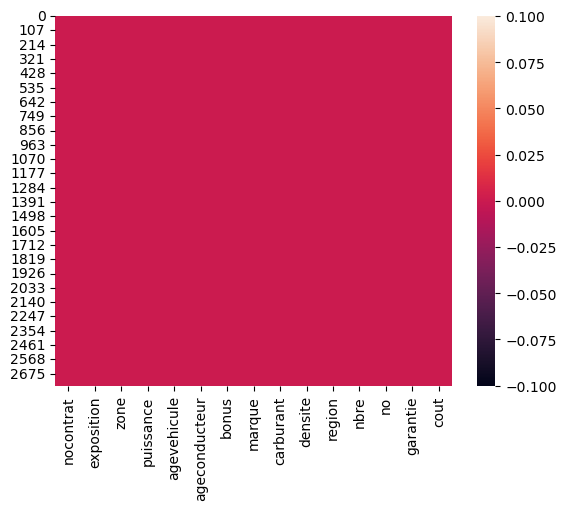

In [19]:
sns.heatmap(Actuar.isnull())


In [21]:
# Vérifier les doublons dans l'ensemble du DataFrame
Actuar.duplicated().sum()

0

## Visualisation et analyse des valeurs aberrantes
Une valeur aberrante est une valeur qui s'écarte fortement des valeurs des autres
observations, anormalement faible ou élevée. Dans le cas général elle peut modifier
l’interprétation de la moyenne.

In [24]:
#Suppression des collonnes non pertinentes 
Actuar=Actuar.drop(columns=['nocontrat'])
Actuar=Actuar.drop(columns=['no'])
Actuar=Actuar.drop(columns=['exposition'])
Actuar=Actuar.drop(columns=['region'])
Actuar=Actuar.drop(columns=['marque'])

In [26]:
Actuar.columns

Index(['zone', 'puissance', 'agevehicule', 'ageconducteur', 'bonus',
       'carburant', 'densite', 'nbre', 'garantie', 'cout'],
      dtype='object')

In [28]:
variables_quantitatives=Actuar.select_dtypes(include=['float64','int64']).columns

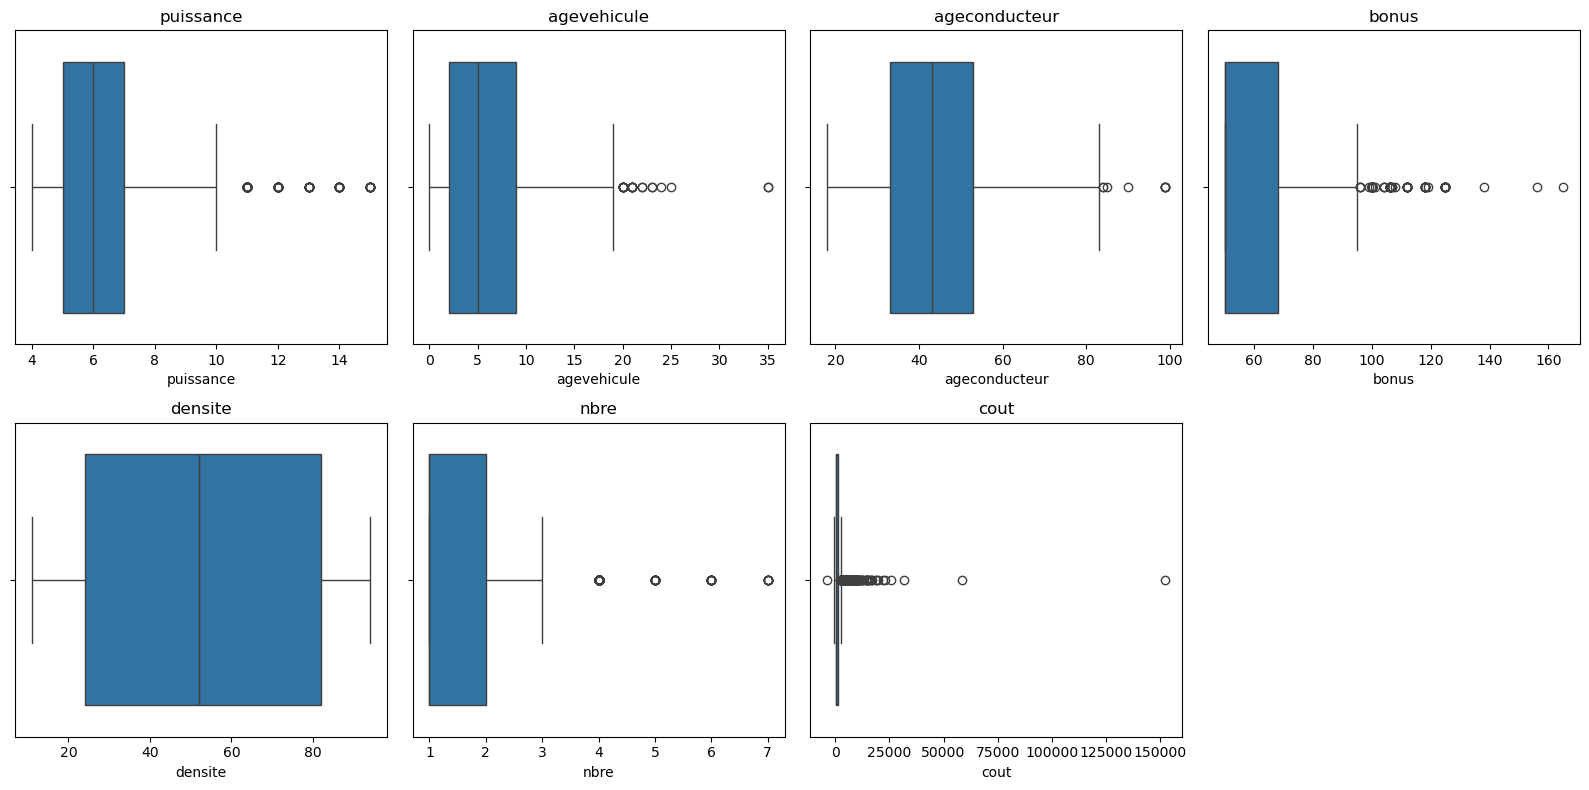

In [30]:

# Créer une disposition en grille pour les sous-graphiques avec 2 lignes et 4 colonnes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Parcourir chaque colonne et créer un diagramme en boîte pour les valeurs aberrantes
for i, colonne in enumerate(variables_quantitatives):
    # Calcul des positions dans la grille
    ligne = i // 4
    col = i % 4
    # Créer un diagramme en boîte pour chaque variable
    sns.boxplot(x=Actuar[colonne], ax=axes[ligne, col])
    axes[ligne, col].set_title(colonne)  # Ajouter le titre de la variable

# Supprimer le dernier sous-graphe vide
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()


## Traitement des valeurs aberrantes
La technique de Winzorisation la technique été utilisée pour traiter ces valeurs
aberrantes en les ramenant à la borne (inférieure et supérieure).

In [33]:
    lower_limit=0.05
    upper_limit=0.95

In [35]:

    def winsorize_dataframe(Actuar, lower_limit, upper_limit):
        """Winsorise les colonnes numériques d'un dataframe."""

   # Winsorise chaque colonne numérique

    for col in variables_quantitatives:
        
        Actuar[col] = winsorize(Actuar[col], limits=[lower_limit, 1 - upper_limit])


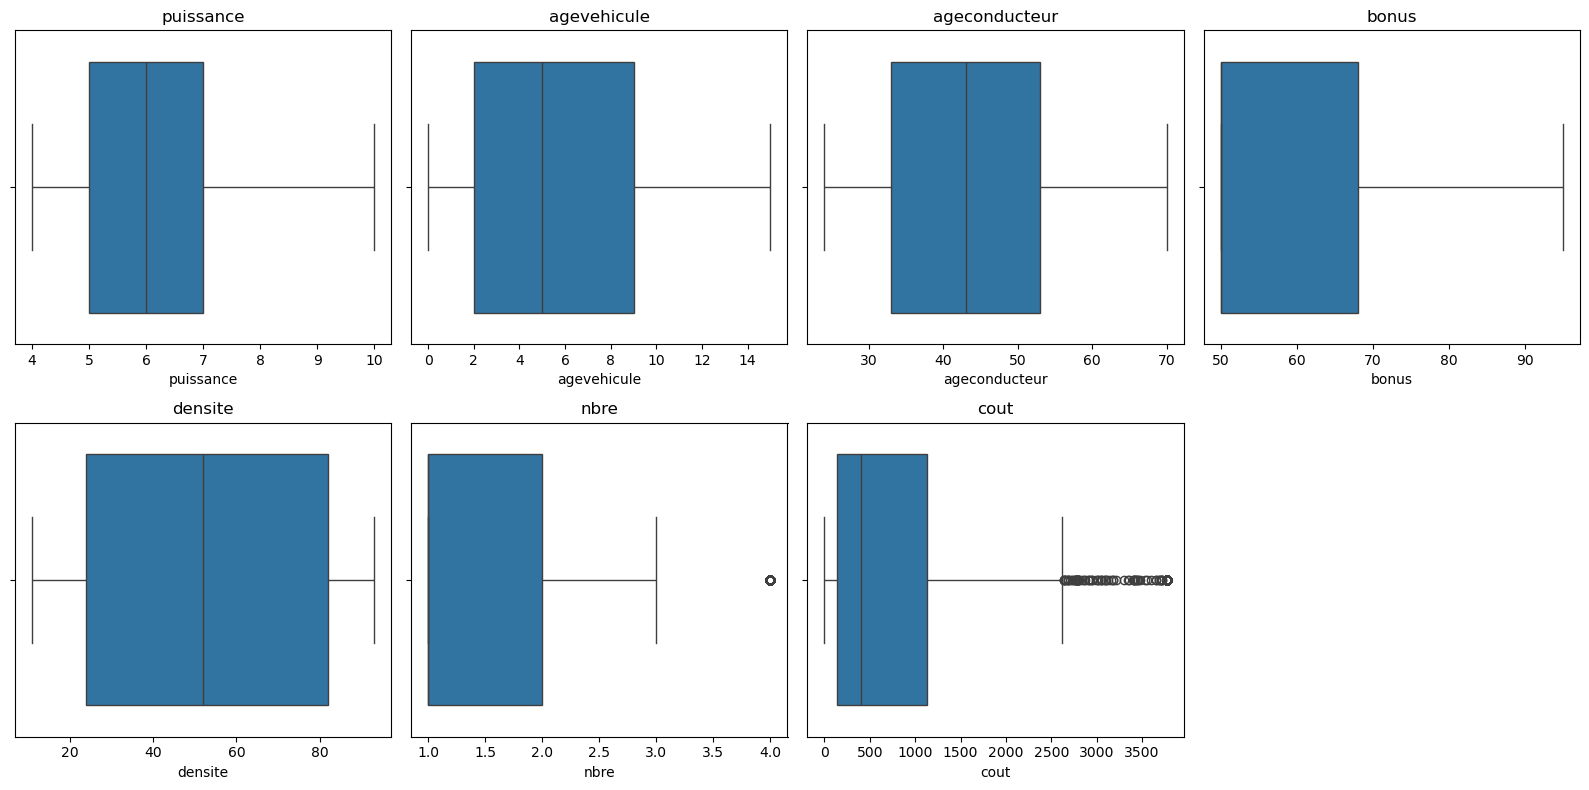

In [37]:
# Créer une disposition en grille pour les sous-graphiques avec 2 lignes et 4 colonnes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Parcourir chaque colonne et créer un diagramme en boîte pour les valeurs aberrantes
for i, colonne in enumerate(variables_quantitatives):
    # Calcul des positions dans la grille
    ligne = i // 4
    col = i % 4
    # Créer un diagramme en boîte pour chaque variable
    sns.boxplot(x=Actuar[colonne], ax=axes[ligne, col])
    axes[ligne, col].set_title(colonne)  # Ajouter le titre de la variable

# Supprimer le dernier sous-graphe vide
fig.delaxes(axes[1, 3])

plt.tight_layout()
plt.show()



## Analyse univariee

## 1- Paramètres statistiques
Cette partie nous permettra d’avoir des informations sur la position générale de la
distribution de chacune des variables quantitatives de nos données. Afin de rendre
compréhensible notre tableau statistique simple, nous a permis de modifier le nom
des variables de notre données.
Ainsi :
- puissance est la variable puissance
- a_vehic est la variable age_vehivcule
- a_cond est la variable age_conducteur
- densite est la variable densite
- nbre est la variable frequence_sinistre
- cout reste la variable cout
- bonus est la variable bonus

In [41]:


Actuar.rename(columns={
    'exposition':'exposition',
    'zone':'zone',
    'puissance':'puissance',
    'agevehicule':'age_vehicule',
    'ageconducteur':'age_conducteur',
    'bonus':'bonus',
    'marque':'marque',
    'carburant':'energie',
    'region':'region',
    'nbre':'frequence_sinistre',
    'garantie':'garantie',
    'cout':'cout'
},inplace=True)

## Tableau statistiques simple des variables quantitatives

In [44]:
Actuar.describe()

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArra

,puissance,age_vehicule,age_conducteur,bonus,densite,frequence_sinistre,cout
count,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000,2765.000000
mean,6.286076,6.088969,43.861121,60.540325,49.106691,1.686076,795.252510
std,1.649312,4.407192,13.072500,14.705930,27.831293,0.868219,964.856737
min,4.000000,0.000000,24.000000,50.000000,11.000000,1.000000,0.000000
25%,5.000000,2.000000,33.000000,50.000000,24.000000,1.000000,132.670000
50%,6.000000,5.000000,43.000000,50.000000,52.000000,1.000000,405.570000
75%,7.000000,9.000000,53.000000,68.000000,82.000000,2.000000,1128.120000
max,10.000000,15.000000,70.000000,95.000000,93.000000,4.000000,3771.690000


Ce tableau présente les statistiques descriptives des colonnes sélectionnées dans le DataFrame `Actuar` :

- **puissance** : La moyenne est de 6,29 avec un écart type de 1,65. Les valeurs vont de 4 à 10.
- **age_vehicule** : La moyenne est de 6,09 ans avec un écart type de 4,41 ans. L'âge des véhicules va de 0 à 15 ans.
- **age_conducteur** : La moyenne est de 43,86 ans avec un écart type de 13,07 ans. L'âge des conducteurs va de 24 à 70 ans.
- **bonus** : La moyenne est de 60,54 avec un écart type de 14,71. Les valeurs vont de 50 à 95.
- **densite** : La moyenne est de 49,11 avec un écart type de 27,83. Les valeurs vont de 11 à 93.
- **frequence_sinistre** : La moyenne est de 1,69 avec un écart type de 0,87. Les valeurs vont de 1 à 4.
- **cout** : La moyenne est de 795,25 avec un écart type de 964,86. Les coûts vont de 0 à 3771,69.

Les quartiles (25%, 50%, 75%) montrent la répartition des données pour chaque colonne.

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


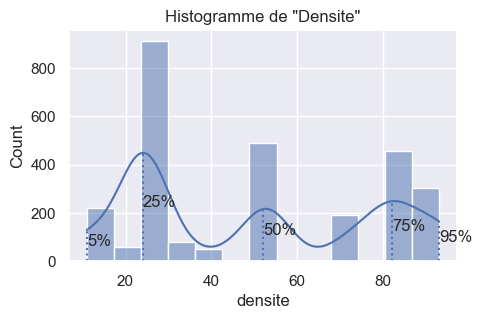

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


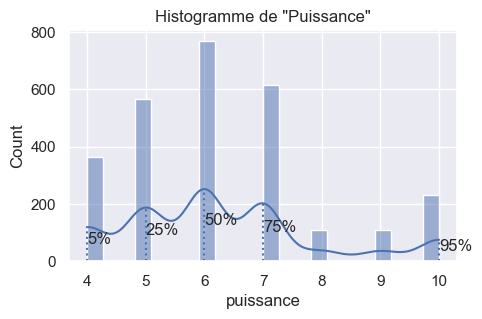

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


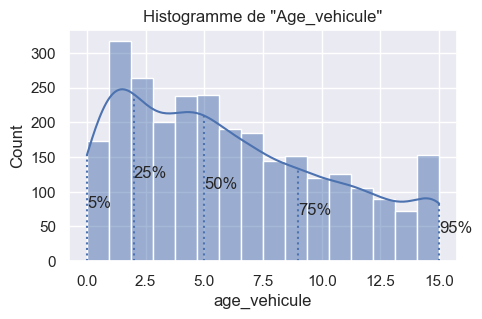

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


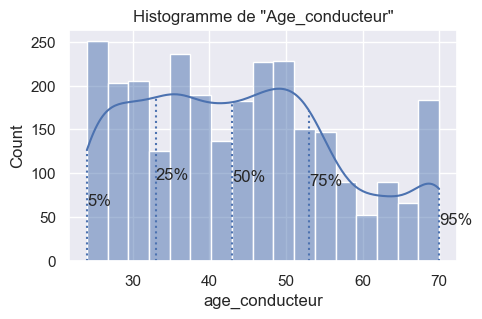

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


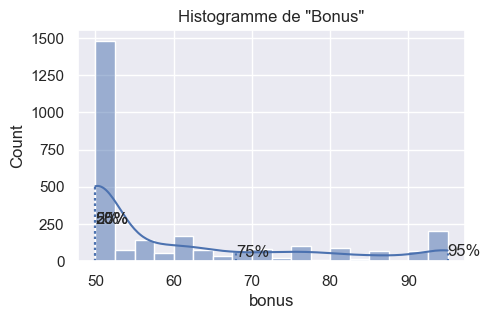

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


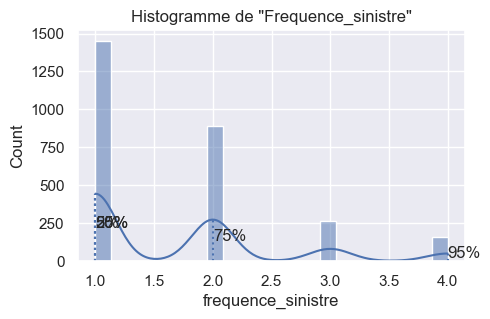

C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\GUERI\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


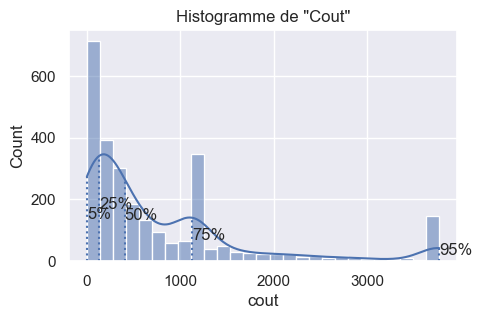

In [48]:

#Densite
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar['densite'], kde=True)
quant_5 = Actuar['densite'].quantile(0.05)
quant_25 = Actuar['densite'].quantile(0.25)
quant_50 = Actuar['densite'].quantile(0.5)
quant_75 = Actuar['densite'].quantile(0.75)
quant_95 = Actuar['densite'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Densite"')
plt.show()

#Puissance
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar['puissance'], kde=True)
quant_5 = Actuar['puissance'].quantile(0.05)
quant_25 = Actuar['puissance'].quantile(0.25)
quant_50 = Actuar['puissance'].quantile(0.5)
quant_75 = Actuar['puissance'].quantile(0.75)
quant_95 = Actuar['puissance'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Puissance"')
plt.show()

#Age_vehicule
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar['age_vehicule'], kde=True)
quant_5 = Actuar['age_vehicule'].quantile(0.05)
quant_25 = Actuar['age_vehicule'].quantile(0.25)
quant_50 = Actuar['age_vehicule'].quantile(0.5)
quant_75 = Actuar['age_vehicule'].quantile(0.75)
quant_95 = Actuar['age_vehicule'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Age_vehicule"')
plt.show()

#Age_conducteur
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar['age_conducteur'], kde=True)
quant_5 = Actuar['age_conducteur'].quantile(0.05)
quant_25 = Actuar['age_conducteur'].quantile(0.25)
quant_50 = Actuar['age_conducteur'].quantile(0.5)
quant_75 = Actuar['age_conducteur'].quantile(0.75)
quant_95 = Actuar['age_conducteur'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Age_conducteur"')
plt.show()

#Bonus
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar['bonus'], kde=True)
quant_5 = Actuar['bonus'].quantile(0.05)
quant_25 = Actuar['bonus'].quantile(0.25)
quant_50 = Actuar['bonus'].quantile(0.5)
quant_75 = Actuar['bonus'].quantile(0.75)
quant_95 = Actuar['bonus'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Bonus"')
plt.show()



#Frequence_sinistre
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar['frequence_sinistre'], kde=True)
quant_5 = Actuar['frequence_sinistre'].quantile(0.05)
quant_25 = Actuar['frequence_sinistre'].quantile(0.25)
quant_50 = Actuar['frequence_sinistre'].quantile(0.5)
quant_75 = Actuar['frequence_sinistre'].quantile(0.75)
quant_95 = Actuar['frequence_sinistre'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Frequence_sinistre"')
plt.show()

#Cout
sns.set(rc = {'figure.figsize':(5,3)})
ax = sns.histplot(x = Actuar['cout'], kde=True)
quant_5 = Actuar['cout'].quantile(0.05)
quant_25 = Actuar['cout'].quantile(0.25)
quant_50 = Actuar['cout'].quantile(0.5)
quant_75 = Actuar['cout'].quantile(0.75)
quant_95 = Actuar['cout'].quantile(0.95)
quant_dict = {'5%': quant_5, '25%': quant_25, '50%': quant_50, '75%': quant_75,'95%': quant_95}
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
for key, value in quant_dict.items():
    height = np.interp(value, xs, ys)
    ax.vlines(value, 0, height, ls=':')
    ax.text(value , height * 0.5, key, rotation=0)
plt.title('Histogramme de "Cout"')
plt.show()

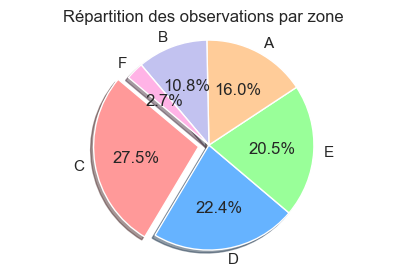

In [51]:
import matplotlib.pyplot as plt

# Données
zones = {
    'C': 0.275399,
    'D': 0.223875,
    'E': 0.204644,
    'A': 0.160377,
    'B': 0.108491,
    'F': 0.027213
}

# Tracer le camembert
labels = zones.keys()
sizes = zones.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6']
explode = (0.1, 0, 0, 0, 0, 0)  # Mettre en avant la zone C

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')  # Assurer que le camembert soit circulaire
plt.title('Répartition des observations par zone')
plt.show()


Le camembert (ou diagramme circulaire) de la variable "zone" montre la répartition proportionnelle des observations dans différentes catégories de zones. Voici une interprétation détaillée des données fournies :

### Interprétation des proportions des zones :

1. **Zone C** : 27,54 %
   - La zone C représente la plus grande part des observations avec 27,54 % du total. Cela signifie qu'un peu plus d'un quart des observations proviennent de cette zone.

2. **Zone D** : 22,39 %
   - La zone D est la deuxième plus grande part avec 22,39 % des observations. Environ un cinquième des observations proviennent de cette zone.

3. **Zone E** : 20,46 %
   - La zone E représente 20,46 % des observations. Elle est également une part significative, proche d'un cinquième des observations.

4. **Zone A** : 16,04 %
   - La zone A compte pour 16,04 % des observations. Un peu moins d'un sixième des observations proviennent de cette zone.

5. **Zone B** : 10,85 %
   - La zone B représente 10,85 % des observations. Elle constitue un peu plus d'un dixième des observations.

6. **Zone F** : 2,72 %
   - La zone F est la moins représentée avec seulement 2,72 % des observations. Cette zone a la plus petite part dans le camembert.

### Interprétation générale :

- **Répartition dominante** : Les zones C, D et E dominent largement la répartition avec plus de 70 % des observations cumulées. Cela montre que la majorité des données proviennent de ces trois zones.
- **Zones moins représentées** : Les zones A et B ont des proportions moindres, mais ensemble, elles comptent tout de même pour environ un quart des observations.
- **Zone marginale** : La zone F est nettement moins représentée avec seulement 2,72 % des observations, ce qui peut indiquer soit une zone géographique moins importante, soit une sous-représentation dans l'échantillon.



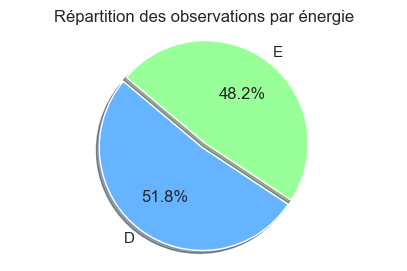

In [54]:
import matplotlib.pyplot as plt

# Données
energie = {
    'D': 0.518142,
    'E': 0.481858
}

# Tracer le camembert
labels = energie.keys()
sizes = energie.values()
colors = ['#66b3ff', '#99ff99']
explode = (0.05, 0)  # Mettre en avant la catégorie D

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')  # Assurer que le camembert soit circulaire
plt.title('Répartition des observations par énergie')
plt.show()

Les données pour la variable "énergie" indiquent la répartition proportionnelle des observations entre deux catégories : D et E. Voici une interprétation détaillée des données fournies :

### Interprétation des proportions de la variable énergie :

1. **Catégorie D** : 51,81 %
   - La catégorie D représente 51,81 % des observations. Cela signifie que légèrement plus de la moitié des observations appartiennent à cette catégorie.

2. **Catégorie E** : 48,19 %
   - La catégorie E représente 48,19 % des observations. Cela signifie que légèrement moins de la moitié des observations appartiennent à cette catégorie.

### Interprétation générale :

- **Répartition équilibrée** : Les proportions des catégories D et E sont assez équilibrées, avec une légère prédominance de la catégorie D. La différence entre les deux catégories est relativement faible (environ 3,62 %), indiquant une distribution presque égale des observations entre les deux catégories d'énergie.



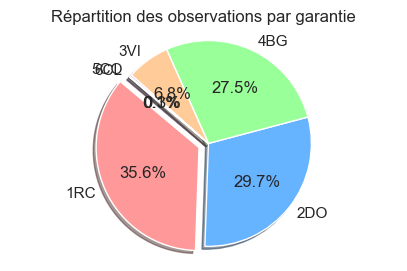

In [57]:
import matplotlib.pyplot as plt

# Données
garantie = {
    '1RC': 0.355588,
    '2DO': 0.296807,
    '4BG': 0.275399,
    '3VI': 0.067852,
    '5CO': 0.003266,
    '6CL': 0.001089
}

# Tracer le camembert
labels = garantie.keys()
sizes = garantie.values()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
explode = (0.1, 0, 0, 0, 0, 0)  # Mettre en avant la garantie 1RC

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')  # Assurer que le camembert soit circulaire
plt.title('Répartition des observations par garantie')
plt.show()


Les données pour la variable "garantie" indiquent la répartition proportionnelle des observations entre différentes catégories de garanties. Voici une interprétation détaillée des données fournies :

### Interprétation des proportions de la variable garantie :

1. **1RC** : 35,56 %
   - La garantie "1RC" représente la plus grande part des observations avec 35,56 % du total. Cela signifie qu'un peu plus d'un tiers des observations concernent cette garantie.

2. **2DO** : 29,68 %
   - La garantie "2DO" est la deuxième plus importante avec 29,68 % des observations. Presque un tiers des observations concernent cette garantie.

3. **4BG** : 27,54 %
   - La garantie "4BG" représente 27,54 % des observations. Un peu plus d'un quart des observations concernent cette garantie.

4. **3VI** : 6,79 %
   - La garantie "3VI" compte pour 6,79 % des observations. Une proportion moindre, mais significative, des observations concernent cette garantie.

5. **5CO** : 0,33 %
   - La garantie "5CO" représente 0,33 % des observations. Cela montre que très peu d'observations concernent cette garantie.

6. **6CL** : 0,11 %
   - La garantie "6CL" est la moins représentée avec seulement 0,11 % des observations. Cela indique que cette garantie est extrêmement rare dans les données.

### Interprétation générale :

- **Garantie dominante** : Les garanties "1RC", "2DO" et "4BG" dominent largement la répartition avec plus de 90 % des observations cumulées. Cela montre que la majorité des données concernent ces trois types de garanties.
- **Garantie moins représentée** : Les garanties "3VI", "5CO" et "6CL" sont beaucoup moins fréquentes, avec une présence très faible dans les données.
- **Répartition déséquilibrée** : La différence significative entre les garanties dominantes et les moins représentées indique une répartition fortement déséquilibrée des types de garanties.



## Analyse Bivariee

**ANALYSE DES VARIABLES QUANTITATIVES AVEC LA VARIABLE COUT**

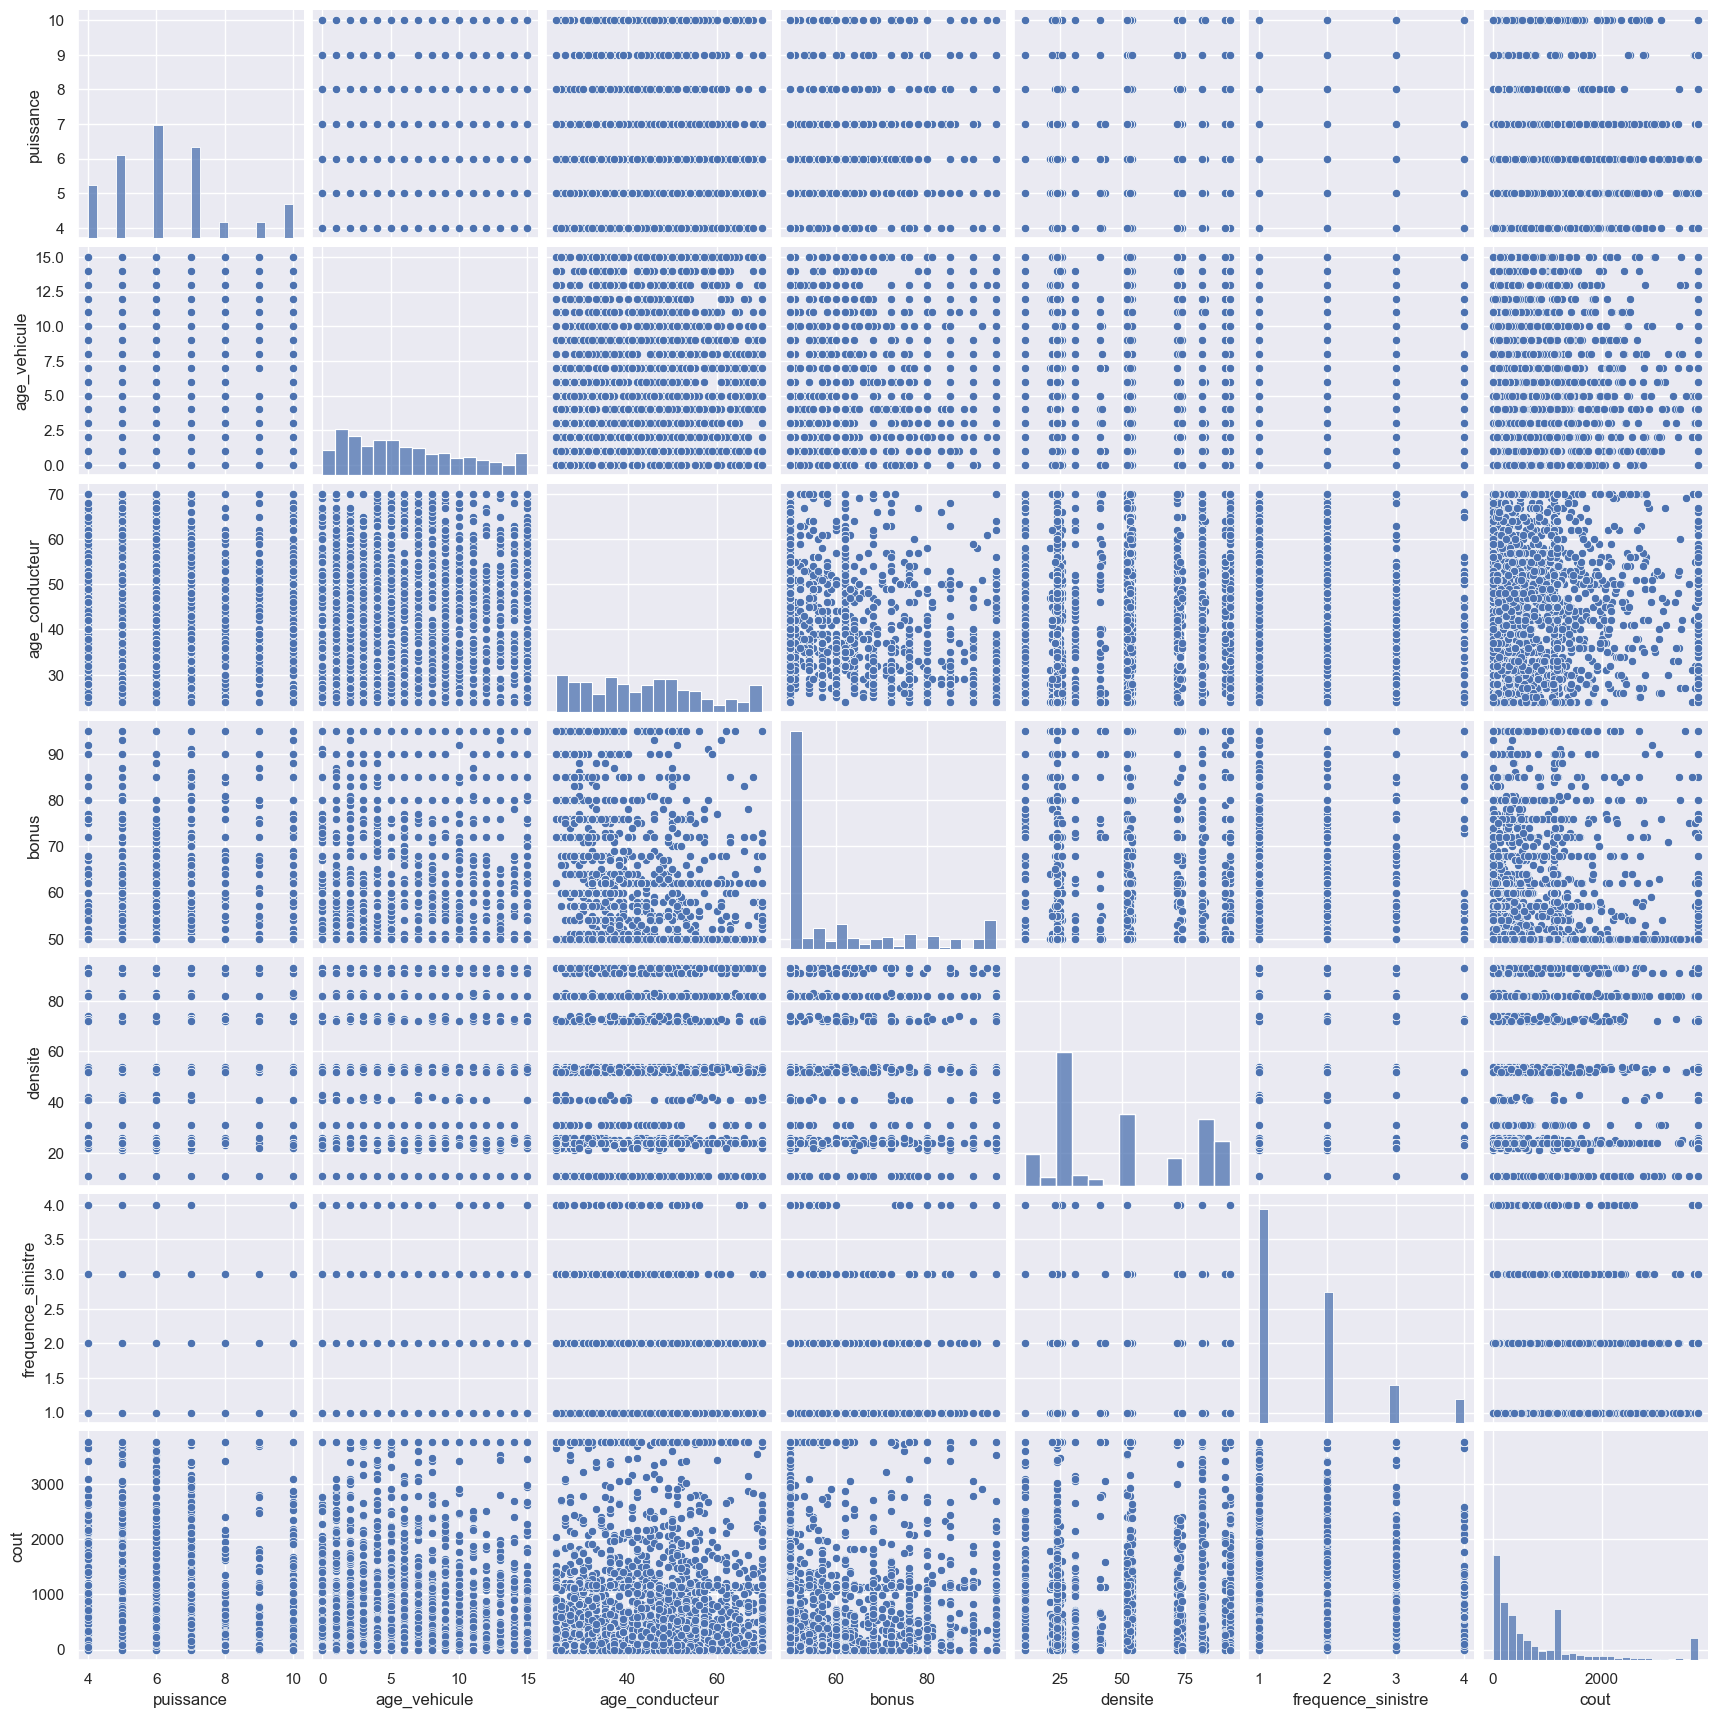

In [61]:
sns.pairplot(data=Actuar)

In [62]:
#Définition d'une fonction slrViz_corr
def slrViz_corr(var):
    sns.regplot(x = var, y = Actuar['cout'])
    plt.ylim(0,)
    Pearson_coef, P_value = stats.pearsonr(var, Actuar['cout'])

    return print('Le coefficient de corrélation de Pearson est', Pearson_coef, 'avec une P-valeur de', P_value)

Le coefficient de corrélation de Pearson est 0.054757699013381844 avec une P-valeur de 0.003974258493305074


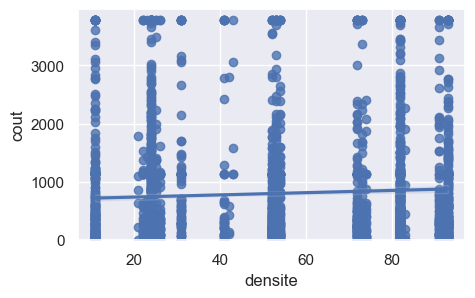

In [63]:
#Régression linéaire simple de 'cout' en fonction de 'densite'
slrViz_corr(Actuar['densite'])


Le graphe ci-contre présente une droite de régression ascendante montrant ainsi un rapport de corrélation positif.On peut donc affirmer que les variables en présences sont liées. Cependant, on peut aussi ajouter que cette liaison est
faible mais possède une intensité plus élevée que celle du graphe 6 en valeur absolue.

Le coefficient de corrélation de Pearson est de 0,0548 avec une p-valeur de 0,00397 pour la relation entre le coût des sinistres et la densité. Cela indique une très faible corrélation positive entre ces deux variables, mais cette relation est statistiquement significative en raison de la faible p-valeur.

Le coefficient de corrélation de Pearson est 0.0032406539126422175 avec une P-valeur de 0.8647525335854095


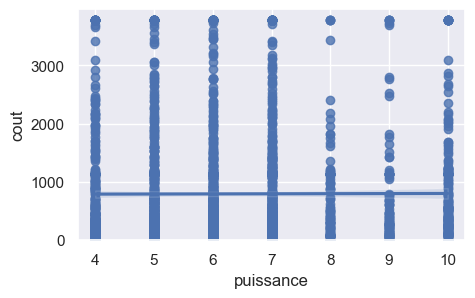

In [65]:
#Régression linéaire simple de 'cout' en fonction de 'puissance'
slrViz_corr(Actuar['puissance'])

 Les points sont éparpillés avec dissimilarité. En effet,L’évolution de la puissance du véhicule ne semble pas avoir d’effet considérable sur le cout du sinistre. On peut donc supposer à première vu que les deux variables ne sont pas liées.Cependant, un test de liaison sera utile si besoin.

Le coefficient de corrélation de Pearson est de 0,0032 avec une p-valeur de 0,8648 pour la relation entre le coût des sinistres et la puissance des véhicules. Cela indique qu'il n'y a pratiquement aucune corrélation entre ces deux variables, et la relation n'est pas statistiquement significative.

Le coefficient de corrélation de Pearson est -0.06213038202439029 avec une P-valeur de 0.0010804304716903975


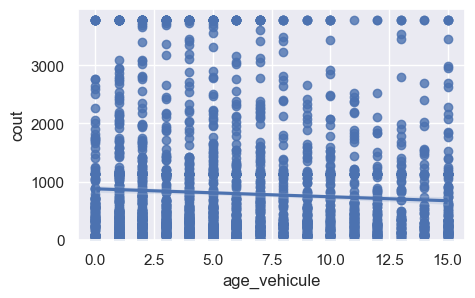

In [67]:
#Régression linéaire simple de 'cout' en fonction de 'age_vehicule'
slrViz_corr(Actuar['age_vehicule'])

L’analyse semble, légèrement Difficile mais on peut clairement voir que la droite de régression issue de ces deux variables décroitre. On en déduit que les variables en présences sont liées mais d’une très faible intensité de liaison négatives.

Le coefficient de corrélation de Pearson est de -0,0621 avec une p-valeur de 0,00108 pour la relation entre le coût des sinistres et l'âge du véhicule. Cela indique une très faible corrélation négative entre ces deux variables, mais cette relation est statistiquement significative en raison de la faible p-valeur.

Le coefficient de corrélation de Pearson est 0.017773200198055665 avec une P-valeur de 0.35018828913776584


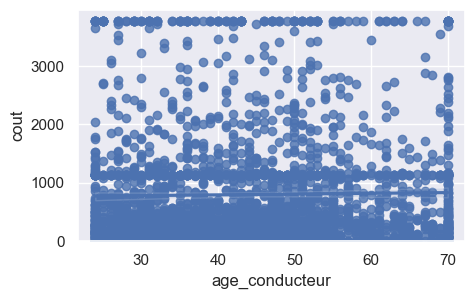

In [69]:
#Régression linéaire simple de 'cout' en fonction de 'age_conduteur'
slrViz_corr(Actuar['age_conducteur'])

De même que le graphe 5 L’analyse semble, légèrement Difficile. Difficile au point ou on peine à voir une quelconque liaison entre ces deux variables. Sauf erreur d’observation, tout porte à croire que ces deux variables sont indépendantes car la droite de régression est une constante.

Le coefficient de corrélation de Pearson est de 0,0178 avec une p-valeur de 0,3502 pour la relation entre le coût des sinistres et l'âge du conducteur. Cela indique qu'il n'y a pratiquement aucune corrélation entre ces deux variables, et la relation n'est pas statistiquement significative.

Le coefficient de corrélation de Pearson est 0.025458043224349833 avec une P-valeur de 0.1808056129844234


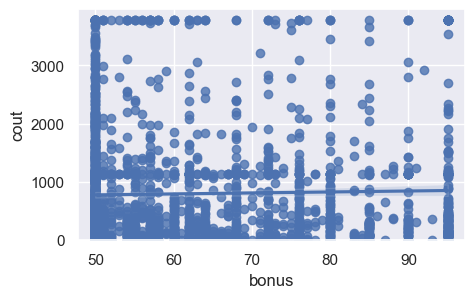

In [71]:
#Régression linéaire simple de 'cout' en fonction de 'bonus'
slrViz_corr(Actuar['bonus'])

Le graphe ci-contre présente une droite de régression presque ascendante montrant ainsi un rapport de corrélation presque
nul. On peut donc affirmer que la majoration ou minoration de coefficients, ne peuvent modifier le cout du sinistre.

Le coefficient de corrélation de Pearson est de 0,0255 avec une p-valeur de 0,1808 pour la relation entre le coût des sinistres et le bonus. Cela indique qu'il n'y a pratiquement aucune corrélation entre ces deux variables, et la relation n'est pas statistiquement significative à un niveau de confiance habituel.

Le coefficient de corrélation de Pearson est 0.05820300113685126 avec une P-valeur de 0.002200723730272265


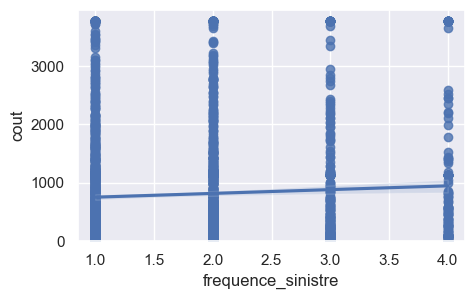

In [73]:
#Régression linéaire simple de 'cout' en fonction de 'frequence_sinistre'
slrViz_corr(Actuar['frequence_sinistre'])

L’observation u graphique montre clairement que l’évolution du nombre de chauffeurs par véhicule augmente positivement et significativement la valeur du cout du sinistre. Cette augmentation positive montre que les variables sont liées positivement. Mais cette intensité reste tout de même

Le coefficient de corrélation de Pearson est de 0,0582 avec une p-valeur de 0,00220 pour la relation entre le coût des sinistres et la fréquence des sinistres. Cela indique une très faible corrélation positive entre ces deux variables, et cette relation est statistiquement significative en raison de la faible p-valeur.

## Matrice de corrélation
La matrice des corrélations permet d’établir les différentes relations qui existent entre les variables. Si le coefficient pour deux variables différentes est proche de 1, alors on en déduit que ces variables sont fortement corrélées et sont très proches dans les projections. Cette matrice des corrélations nous permet de voir les différentes relations entre les variables : Puissance, a_vehic, a_cond, Densité, Nbre, imc, Bonus, Cout.

In [76]:
# Calcul de la matrice de corrélation
corr_matrix = Actuar.corr()


plt.figure(figsize=(12, 10))
# Affichage de la matrice de corrélation sous forme de heatmap avec seaborn
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

ValueError: could not convert string to float: 'A'

- Toute variable corrélée avec elle-même vaut 1.
- La corrélation entre les variables nombre de chauffeur du véhicule et âge du véhicule puis Coefficient de réduction-majoration et âge du conducteur représentée par la couleur rouge sont fortement corrélées.
- Les autres corrélations représentées par la couleur marron ont une intensité moyenne.
- Quant à celle en vert, l’intensité existe mais reste très faible.

**ANALYSE DES VARIABLES QUALITATIVES AVES LA VARIABLE COUT**

### Analyse graphique
Le graphe ci-dessous montre un alignement presque parfait de la médiane des modalités de la variable zone en fonction du de la variable cout du sinistre. Ce qui nous amène à conclure que les deux variables des significativement indépendantes

In [ ]:
sns.violinplot(x = 'zone', y = 'cout', data = Actuar,hue='zone')


In [ ]:
sns.violinplot(x = 'energie', y = 'cout', data = Actuar,hue='energie')


In [ ]:
sns.violinplot(x = 'garantie', y = 'cout', data = Actuar,hue='garantie')


In [ ]:
variables_qualitatives=Actuar.select_dtypes(include=['object'])

In [81]:
from scipy.stats import chi2_contingency


# Initialiser les listes pour stocker les résultats
var_names = []
chi2_stats = []
p_values = []
cramer_vs = []

# Parcourir toutes les variables qualitatives
for var in variables_qualitatives:
    # Calculer le tableau de contingence
    contingency_table = pd.crosstab(Actuar['cout'], Actuar[var])
    # Calculer la statistique de test du Chi-deux et la p-valeur
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # Calculer le coefficient V de Cramer
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rc = r - ((r - 1) ** 2) / (n - 1)
    kc = k - ((k - 1) ** 2) / (n - 1)
    cramer_v = np.sqrt(phi2corr / min(rc - 1, kc - 1))
    # Ajouter les résultats aux listes correspondantes
    var_names.append(var)
    chi2_stats.append(chi2)
    p_values.append(p)
    cramer_vs.append(cramer_v)

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    'Variable': var_names,
    'Chi2': chi2_stats,
    'P-valeur': p_values,
    'V de Cramer': cramer_vs
})

# Trier le DataFrame par ordre croissant de V de Cramer
results_df.sort_values(by='V de Cramer', inplace=True, ascending=False)

# Afficher le tableau des résultats
print(results_df)

NameError: name 'variables_qualitatives' is not defined

- Pour la variable "énergie", le Chi2 est de 1972.708752 avec une p-valeur de 0.484913 et un V de Cramer de 0.01898. Cela indique une faible association entre le coût et la variable "énergie".
- Pour la variable "zone", le Chi2 est de 9693.252585 avec une p-valeur de 0.875692 et un V de Cramer de 0.00000. Il semble qu'il n'y ait pas d'association entre le coût et la variable "zone".
Pour la variable "garantie", le Chi2 est de 8638.661475 avec une p-valeur de 1.000000 et un V de Cramer de 0.00000. Cela suggère qu'il n'y a pas d'association entre le coût et la variable "garantie".

In [84]:
from sklearn.preprocessing import LabelEncoder


In [86]:

encoded=LabelEncoder().fit_transform(Actuar['zone'])
encoded=LabelEncoder().fit_transform(Actuar['energie'])
encoded=LabelEncoder().fit_transform(Actuar['garantie'])

Actuar['zone']=encoded
Actuar['energie']=encoded
Actuar['garantie']=encoded

Actuar.head()

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,frequence_sinistre,garantie,cout
0,0,5,4,31,64,0,21,1,0,0.00
1,0,7,8,24,95,0,26,1,0,0.00
2,3,9,0,32,61,3,41,1,3,687.82
3,1,7,5,39,95,1,11,1,1,96.64
4,1,4,0,49,50,1,31,1,1,70.88


<Axes: >

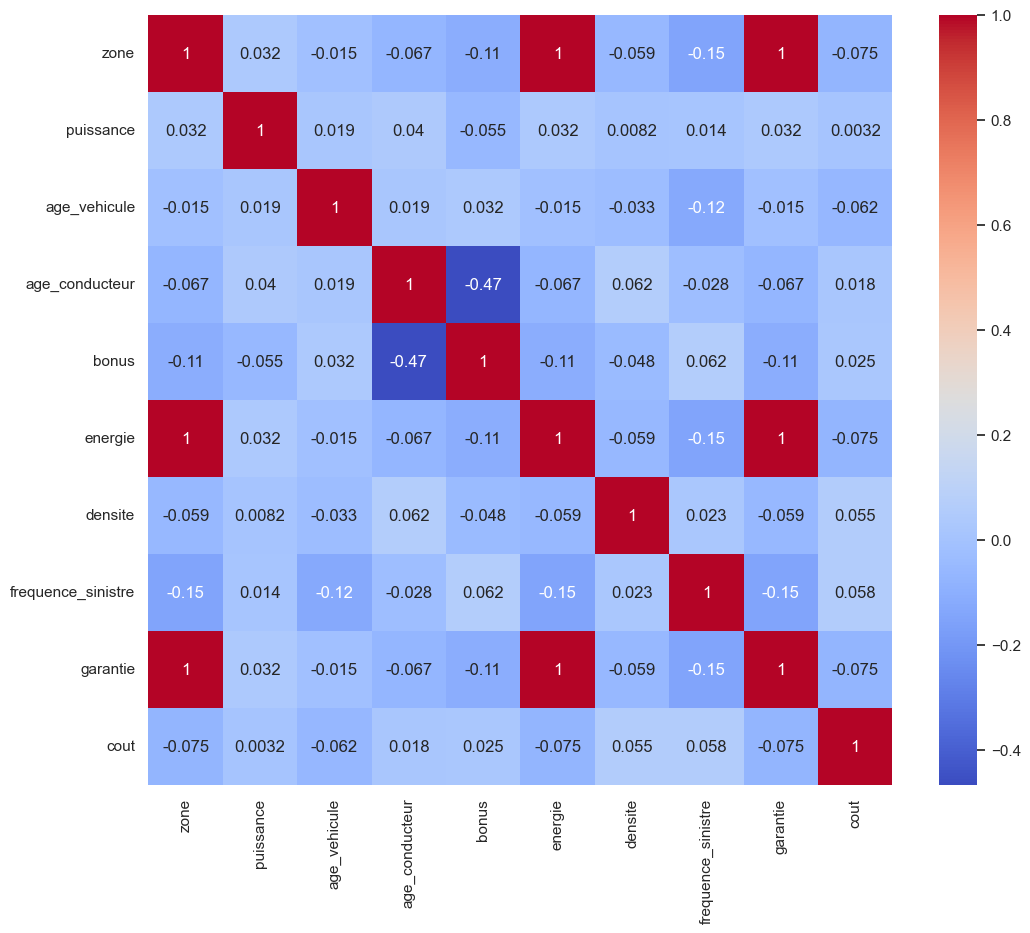

In [89]:
# Calcul de la matrice de corrélation
corr_matrix = Actuar.corr()


plt.figure(figsize=(12, 10))
# Affichage de la matrice de corrélation sous forme de heatmap avec seaborn
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [101]:
# Sélection des variables numériques
num_vars = Actuar.select_dtypes(include=[np.number])

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler = StandardScaler()
df_normalized = scaler.fit_transform(Actuar)







In [113]:

# Calcul de l'ACP
pca = PCA()
pca.fit(df_normalized)





PCA()

In [115]:
# 1. Calcul des valeurs propres
valeurs_propres = pca.explained_variance_
print("Valeurs propres:", valeurs_propres)

Valeurs propres: [3.06973521e+00 1.49274432e+00 1.16324449e+00 9.98519268e-01
 9.87734201e-01 9.34793563e-01 8.45700520e-01 5.11146375e-01
 8.74508428e-17 0.00000000e+00]


In [119]:
import pandas as pd
import numpy as np

# 1. Calcul des valeurs propres, variance expliquée et variance cumulée
valeurs_propres = pca.explained_variance_
variance_expliquee = pca.explained_variance_ratio_
variance_cumulee = np.cumsum(variance_expliquee)

# Création d'un DataFrame pour afficher les résultats dans un tableau
df_resultats = pd.DataFrame({
    "Valeurs Propres": valeurs_propres,
    "Pourcentage de Variance (%)": variance_expliquee * 100,
    "Pourcentage de Variance Cumulée (%)": variance_cumulee * 100
}, index=[f"Composante {i+1}" for i in range(len(valeurs_propres))])

# Affichage du tableau
print(df_resultats)



               Valeurs Propres  Pourcentage de Variance (%)  \
Composante 1      3.069735e+00                 3.068625e+01   
Composante 2      1.492744e+00                 1.492204e+01   
Composante 3      1.163244e+00                 1.162824e+01   
Composante 4      9.985193e-01                 9.981581e+00   
Composante 5      9.877342e-01                 9.873770e+00   
Composante 6      9.347936e-01                 9.344555e+00   
Composante 7      8.457005e-01                 8.453947e+00   
Composante 8      5.111464e-01                 5.109615e+00   
Composante 9      8.745084e-17                 8.741921e-16   
Composante 10     0.000000e+00                 0.000000e+00   

               Pourcentage de Variance Cumulée (%)  
Composante 1                             30.686250  
Composante 2                             45.608294  
Composante 3                             57.236532  
Composante 4                             67.218114  
Composante 5                             

In [121]:
# 2. Choix du nombre d'axes : On choisit un nombre d'axes en fonction de la variance expliquée (exemple 90%)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)



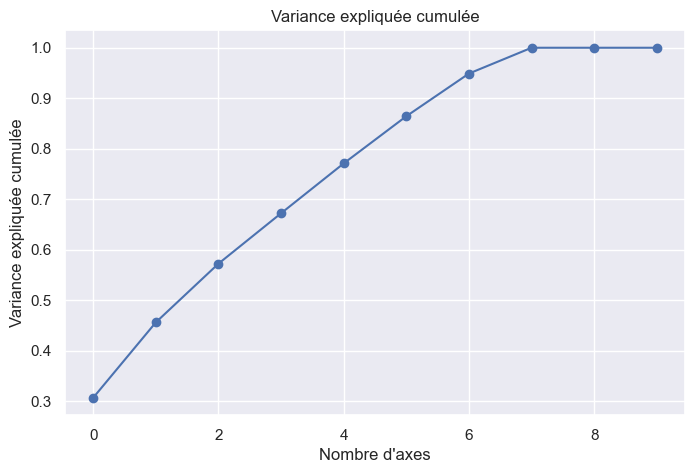

In [123]:
# Affichage de la variance expliquée cumulée
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.title("Variance expliquée cumulée")
plt.xlabel("Nombre d'axes")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True)
plt.show()

In [125]:
# Choisir le nombre d'axes qui expliquent 90% de la variance
n_axes = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Nombre d'axes à retenir pour expliquer 90% de la variance : {n_axes}")

Nombre d'axes à retenir pour expliquer 90% de la variance : 7


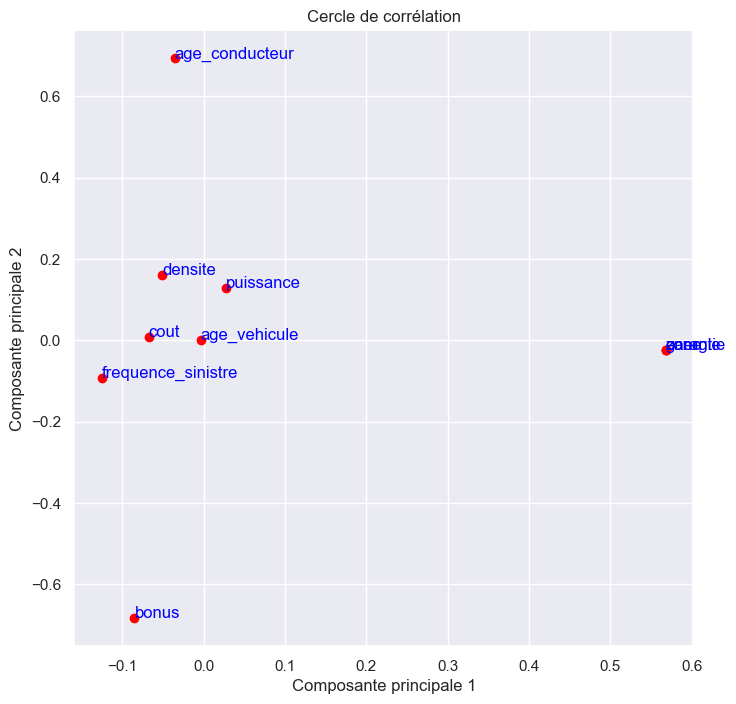

In [133]:
# 3. Cercle de corrélation : Visualisation des corrélations entre les variables et les composantes principales
correlation_matrix = np.corrcoef(df_normalized.T)
plt.figure(figsize=(8, 8))
plt.scatter(pca.components_[0], pca.components_[1], color='red')
for i, var in enumerate(Actuar.columns):
    plt.text(pca.components_[0][i], pca.components_[1][i], var, color='blue')
plt.title("Cercle de corrélation")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

In [135]:

# 4. Visualisation de la contribution des variables sur les axes principaux
# Projection des données sur les premiers axes
df_pca = pca.transform(df_normalized)


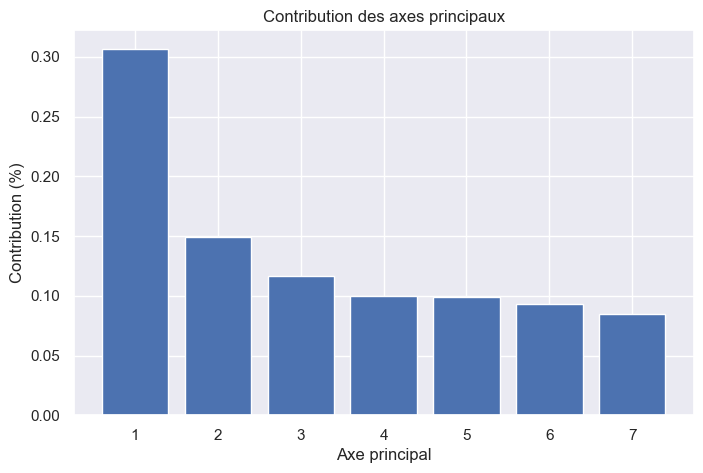

In [137]:

# Affichage des contributions
plt.figure(figsize=(8, 5))
plt.bar(range(1, n_axes + 1), pca.explained_variance_ratio_[:n_axes])
plt.title("Contribution des axes principaux")
plt.xlabel("Axe principal")
plt.ylabel("Contribution (%)")
plt.grid(True)
plt.show()



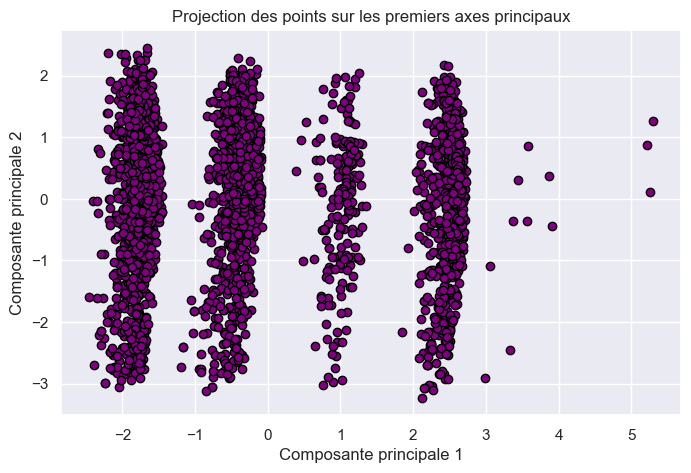

In [139]:
# Visualisation des points projetés sur les premiers axes
plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c='purple', edgecolor='black')
plt.title("Projection des points sur les premiers axes principaux")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

In [105]:
# Analyse en Composantes Principales (ACP)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)



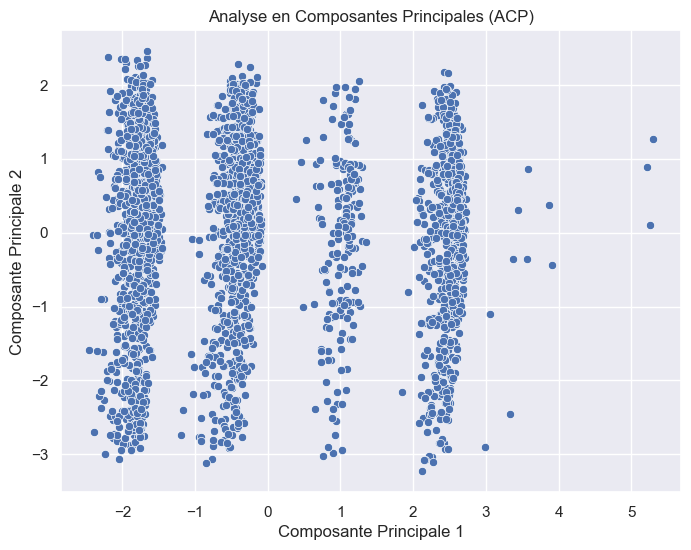

In [107]:
# Visualisation des deux premières composantes principales
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Analyse en Composantes Principales (ACP)')
plt.show()



In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chargement des données (Remplacer par votre dataset)

# Normalisation des données
scaler = StandardScaler()
df_normalized = scaler.fit_transform(Actuar)




In [147]:
# Calcul de l'ACP
pca = PCA()
pca.fit(df_normalized)

# 1️⃣ Tableau des valeurs propres et de la variance expliquée
valeurs_propres = pca.explained_variance_
variance_expliquee = pca.explained_variance_ratio_
variance_cumulee = np.cumsum(variance_expliquee)

df_resultats = pd.DataFrame({
    "Valeurs Propres": valeurs_propres,
    "Pourcentage de Variance (%)": variance_expliquee * 100,
    "Pourcentage de Variance Cumulée (%)": variance_cumulee * 100
}, index=[f"Composante {i+1}" for i in range(len(valeurs_propres))])

print(df_resultats)



               Valeurs Propres  Pourcentage de Variance (%)  \
Composante 1      3.069735e+00                 3.068625e+01   
Composante 2      1.492744e+00                 1.492204e+01   
Composante 3      1.163244e+00                 1.162824e+01   
Composante 4      9.985193e-01                 9.981581e+00   
Composante 5      9.877342e-01                 9.873770e+00   
Composante 6      9.347936e-01                 9.344555e+00   
Composante 7      8.457005e-01                 8.453947e+00   
Composante 8      5.111464e-01                 5.109615e+00   
Composante 9      8.745084e-17                 8.741921e-16   
Composante 10     0.000000e+00                 0.000000e+00   

               Pourcentage de Variance Cumulée (%)  
Composante 1                             30.686250  
Composante 2                             45.608294  
Composante 3                             57.236532  
Composante 4                             67.218114  
Composante 5                             

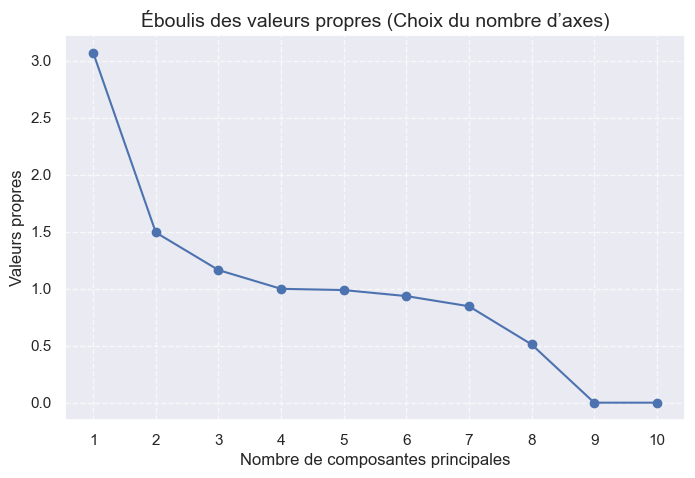

In [161]:
# 2️⃣ Graphique du choix des axes (Éboulis des valeurs propres)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(valeurs_propres) + 1), valeurs_propres, marker='o', linestyle='-', color='b')
plt.title("Éboulis des valeurs propres (Choix du nombre d’axes)", fontsize=14)
plt.xlabel("Nombre de composantes principales", fontsize=12)
plt.ylabel("Valeurs propres", fontsize=12)
plt.xticks(range(1, len(valeurs_propres) + 1))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

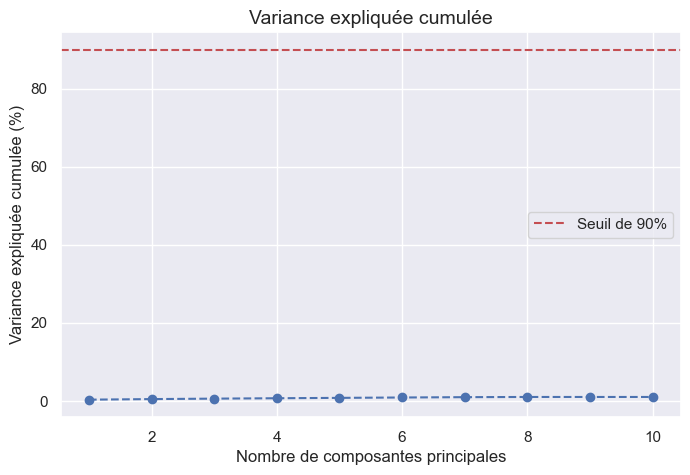

In [163]:
# 2️⃣ Graphique de la variance expliquée cumulée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance_cumulee) + 1), variance_cumulee, marker='o', linestyle='--', color='b')
plt.axhline(y=90, color='r', linestyle='--', label="Seuil de 90%")
plt.title("Variance expliquée cumulée", fontsize=14)
plt.xlabel("Nombre de composantes principales", fontsize=12)
plt.ylabel("Variance expliquée cumulée (%)", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()



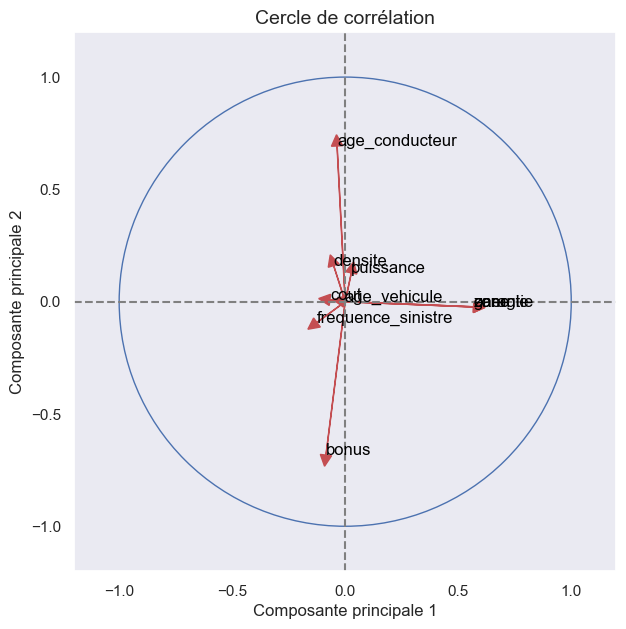

In [151]:
# 3️⃣ Cercle de corrélation (Projection des variables sur les deux premiers axes)
components = pca.components_
fig, ax = plt.subplots(figsize=(7, 7))

# Tracé du cercle unité
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_patch(circle)

# Ajout des flèches et des labels des variables
for i, var in enumerate(Actuar.columns):
    plt.arrow(0, 0, components[0, i], components[1, i], head_width=0.05, head_length=0.05, color='r')
    plt.text(components[0, i], components[1, i], var, color='black', fontsize=12)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.title("Cercle de corrélation", fontsize=14)
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.grid()
plt.show()



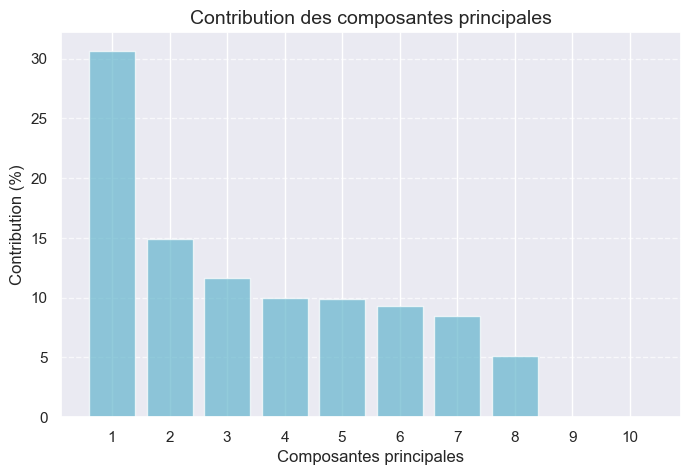

In [153]:
# 4️⃣ Graphique de la contribution des composantes
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(variance_expliquee) + 1), variance_expliquee * 100, color='c', alpha=0.7)
plt.title("Contribution des composantes principales", fontsize=14)
plt.xlabel("Composantes principales", fontsize=12)
plt.ylabel("Contribution (%)", fontsize=12)
plt.xticks(range(1, len(variance_expliquee) + 1))
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()



In [ ]:
# 5️⃣ Projection des individus sur le premier plan factoriel
df_pca = pca.transform(df_normalized)
plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c='purple', edgecolor='black', alpha=0.7)
plt.title("Projection des individus sur le premier plan factoriel", fontsize=14)
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

               Valeurs Propres  Pourcentage de Variance (%)  \
Composante 1      3.069735e+00                 3.068625e+01   
Composante 2      1.492744e+00                 1.492204e+01   
Composante 3      1.163244e+00                 1.162824e+01   
Composante 4      9.985193e-01                 9.981581e+00   
Composante 5      9.877342e-01                 9.873770e+00   
Composante 6      9.347936e-01                 9.344555e+00   
Composante 7      8.457005e-01                 8.453947e+00   
Composante 8      5.111464e-01                 5.109615e+00   
Composante 9      8.745084e-17                 8.741921e-16   
Composante 10     0.000000e+00                 0.000000e+00   

               Pourcentage de Variance Cumulée (%)  
Composante 1                             30.686250  
Composante 2                             45.608294  
Composante 3                             57.236532  
Composante 4                             67.218114  
Composante 5                             

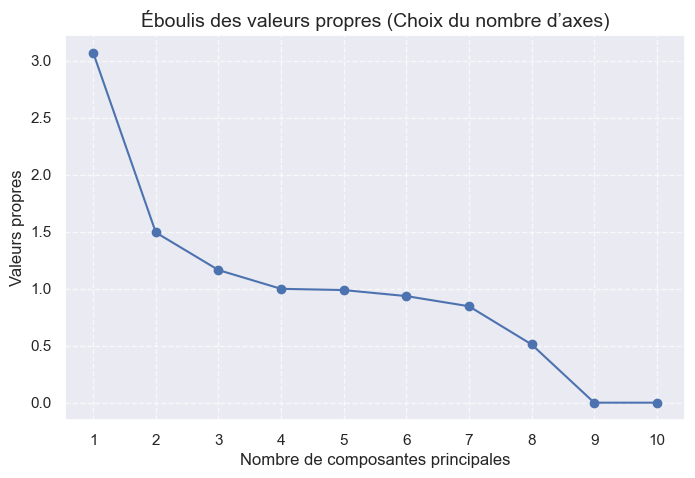

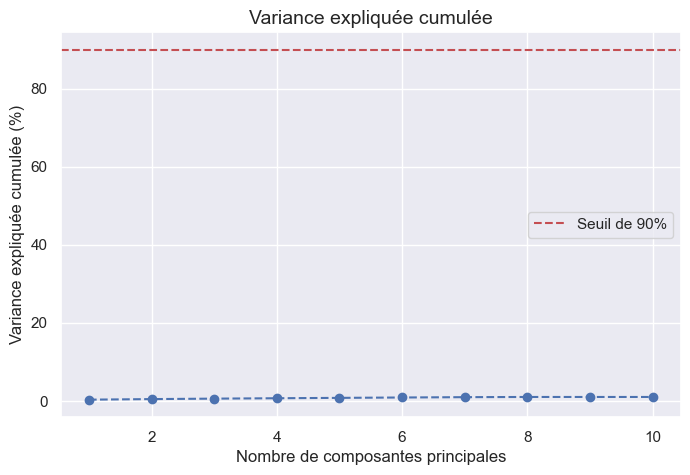

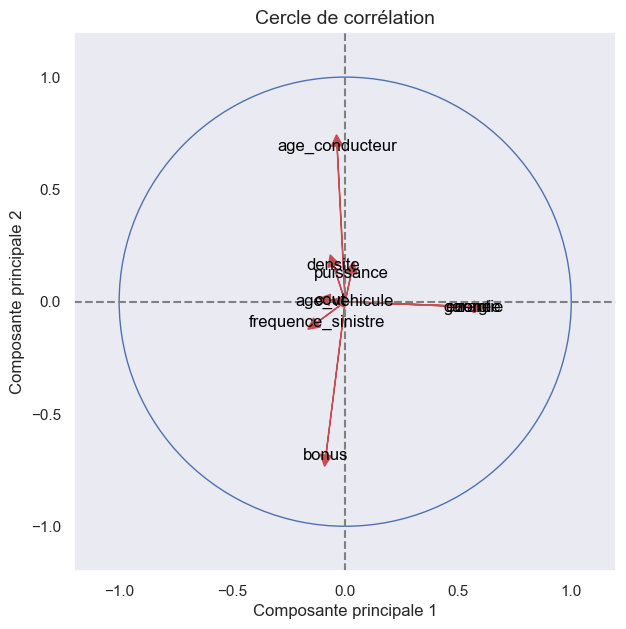

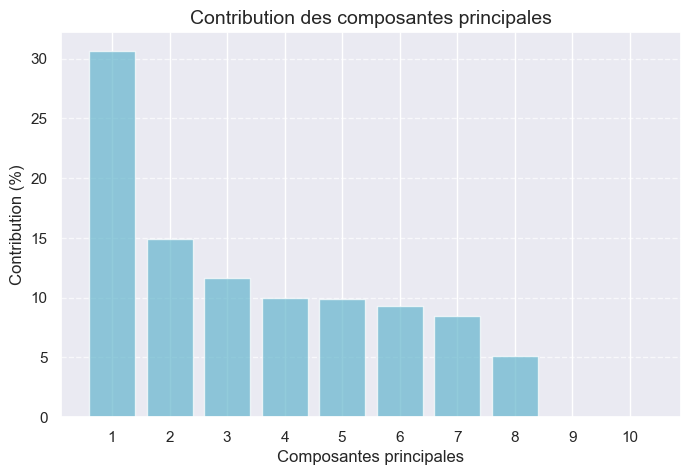

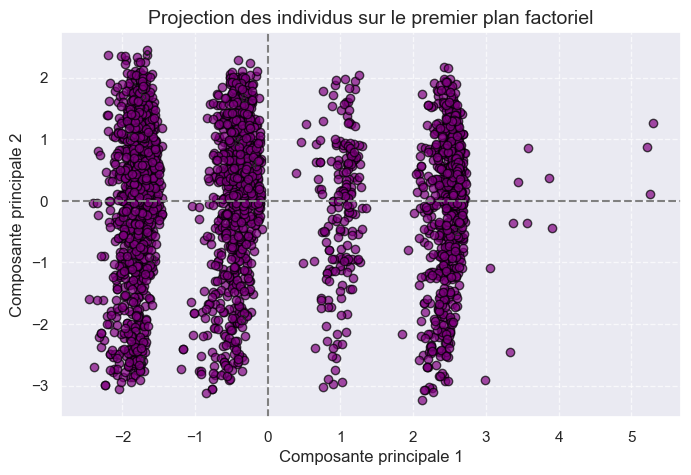

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chargement des données (Remplacer par votre dataset)

# Normalisation des données
scaler = StandardScaler()
df_normalized = scaler.fit_transform(Actuar)

# Calcul de l'ACP
pca = PCA()
pca.fit(df_normalized)

# 1️⃣ Tableau des valeurs propres et de la variance expliquée
valeurs_propres = pca.explained_variance_
variance_expliquee = pca.explained_variance_ratio_
variance_cumulee = np.cumsum(variance_expliquee)

df_resultats = pd.DataFrame({
    "Valeurs Propres": valeurs_propres,
    "Pourcentage de Variance (%)": variance_expliquee * 100,
    "Pourcentage de Variance Cumulée (%)": variance_cumulee * 100
}, index=[f"Composante {i+1}" for i in range(len(valeurs_propres))])

print(df_resultats)

# 2️⃣ Graphique du choix des axes (Éboulis des valeurs propres)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(valeurs_propres) + 1), valeurs_propres, marker='o', linestyle='-', color='b')
plt.title("Éboulis des valeurs propres (Choix du nombre d’axes)", fontsize=14)
plt.xlabel("Nombre de composantes principales", fontsize=12)
plt.ylabel("Valeurs propres", fontsize=12)
plt.xticks(range(1, len(valeurs_propres) + 1))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# 3️⃣ Graphique de la variance expliquée cumulée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance_cumulee) + 1), variance_cumulee, marker='o', linestyle='--', color='b')
plt.axhline(y=90, color='r', linestyle='--', label="Seuil de 90%")
plt.title("Variance expliquée cumulée", fontsize=14)
plt.xlabel("Nombre de composantes principales", fontsize=12)
plt.ylabel("Variance expliquée cumulée (%)", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# 4️⃣ Cercle de corrélation (Projection des variables)
components = pca.components_
fig, ax = plt.subplots(figsize=(7, 7))

# Tracé du cercle unité
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_patch(circle)

# Ajout des flèches et des labels des variables
for i, var in enumerate(Actuar.columns):
    plt.arrow(0, 0, components[0, i], components[1, i], head_width=0.05, head_length=0.05, color='r')
    plt.text(components[0, i], components[1, i], var, color='black', fontsize=12, ha='center', va='center')

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.title("Cercle de corrélation", fontsize=14)
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.grid()
plt.show()

# 5️⃣ Graphique de la contribution des composantes
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(variance_expliquee) + 1), variance_expliquee * 100, color='c', alpha=0.7)
plt.title("Contribution des composantes principales", fontsize=14)
plt.xlabel("Composantes principales", fontsize=12)
plt.ylabel("Contribution (%)", fontsize=12)
plt.xticks(range(1, len(variance_expliquee) + 1))
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

# 6️⃣ Projection des individus sur le premier plan factoriel avec labels
df_pca = pca.transform(df_normalized)
plt.figure(figsize=(8, 5))

# Ajout des points
plt.scatter(df_pca[:, 0], df_pca[:, 1], c='purple', edgecolor='black', alpha=0.7)

# Ajout des labels des individus (limite à 10 pour lisibilité)
for i in range(min(10, len(Actuar))):  # Ajuste selon la taille du dataset
    plt.text(df_pca[i, 0], df_pca[i, 1], Actuar.index[i], fontsize=9, ha='center', va='center')

plt.title("Projection des individus sur le premier plan factoriel", fontsize=14)
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [109]:
# Affichage de la variance expliquée
print("Variance expliquée par composante :", pca.explained_variance_ratio_)

Variance expliquée par composante : [0.3068625  0.14922044]


In [91]:
# Extraction des variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt
corr_threshold = 0.6
corr_vars = corr_matrix[abs(corr_matrix["cout"]) > corr_threshold].index.tolist()

# Affichage des variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt
print("Variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt (cout) :\n")
print(corr_vars)

Variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt (cout) :

['cout']


In [93]:
# Extraction des variables ayant une corrélation inférieure à -0.6 avec la variable d'intérêt
corr_threshold = -0.6
corr_vars = corr_matrix[abs(corr_matrix["cout"]) < corr_threshold].index.tolist()

# Affichage des variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt
print("Variables ayant une corrélation inférieure à -0.6 avec la variable d'intérêt (cout) :\n")
print(corr_vars)

Variables ayant une corrélation inférieure à -0.6 avec la variable d'intérêt (cout) :

[]


In [47]:
# Extraction des couples de variables ayant une corrélation supérieure à 0.8
corr_threshold = 0.8
corr_pairs = {}

for col in corr_matrix.columns:
    corr_pairs[col] = []
    corr_values = corr_matrix[abs(corr_matrix[col]) > corr_threshold][col].index.tolist()
    for pair in corr_values:
        if pair != col:
            corr_pairs[col].append(pair)

# Affichage des couples de variables ayant une corrélation supérieure à 0.8
print("Couples de variables ayant une corrélation supérieure à 0.8 :\n")
for col, pairs in corr_pairs.items():
    if len(pairs) > 0:
        for pair in pairs:
            print(col, "-", pair)

Couples de variables ayant une corrélation supérieure à 0.8 :

zone - energie
zone - garantie
energie - zone
energie - garantie
garantie - zone
garantie - energie


In [48]:
# Extraction des couples de variables ayant une corrélation inférieure à -0.8
corr_threshold = -0.8
corr_pairs = {}

for col in corr_matrix.columns:
    corr_pairs[col] = []
    corr_values = corr_matrix[abs(corr_matrix[col]) < corr_threshold][col].index.tolist()
    for pair in corr_values:
        if pair != col:
            corr_pairs[col].append(pair)

# Affichage des couples de variables ayant une corrélation inférieure à -0.8
print("Couples de variables ayant une corrélation inférieure à -0.8 :\n")
for col, pairs in corr_pairs.items():
    if len(pairs) > 0:
        for pair in pairs:
            print(col, "-", pair)

Couples de variables ayant une corrélation inférieure à -0.8 :



In [50]:
# Diviser les données en ensembles d'apprentissage et de test

train, test = train_test_split(Actuar, test_size=0.2, random_state=42)

In [51]:
# Résumé statistique des variables
train.describe()

,zone,puissance,age_vehicule,age_conducteur,bonus,energie,densite,frequence_sinistre,garantie,cout
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,1.265371,6.293400,6.106239,44.043400,60.453888,1.265371,49.033454,1.691230,1.265371,799.131759
std,1.220440,1.652894,4.420872,13.088604,14.585023,1.220440,27.877515,0.876372,1.220440,975.741680
min,0.000000,4.000000,0.000000,24.000000,50.000000,0.000000,11.000000,1.000000,0.000000,0.000000
25%,0.000000,5.000000,2.000000,33.000000,50.000000,0.000000,24.000000,1.000000,0.000000,129.190000
50%,1.000000,6.000000,5.000000,43.000000,50.000000,1.000000,52.000000,1.000000,1.000000,405.600000
75%,3.000000,7.000000,9.000000,53.000000,68.000000,3.000000,82.000000,2.000000,3.000000,1128.120000
max,5.000000,10.000000,15.000000,70.000000,95.000000,5.000000,93.000000,4.000000,5.000000,3771.690000


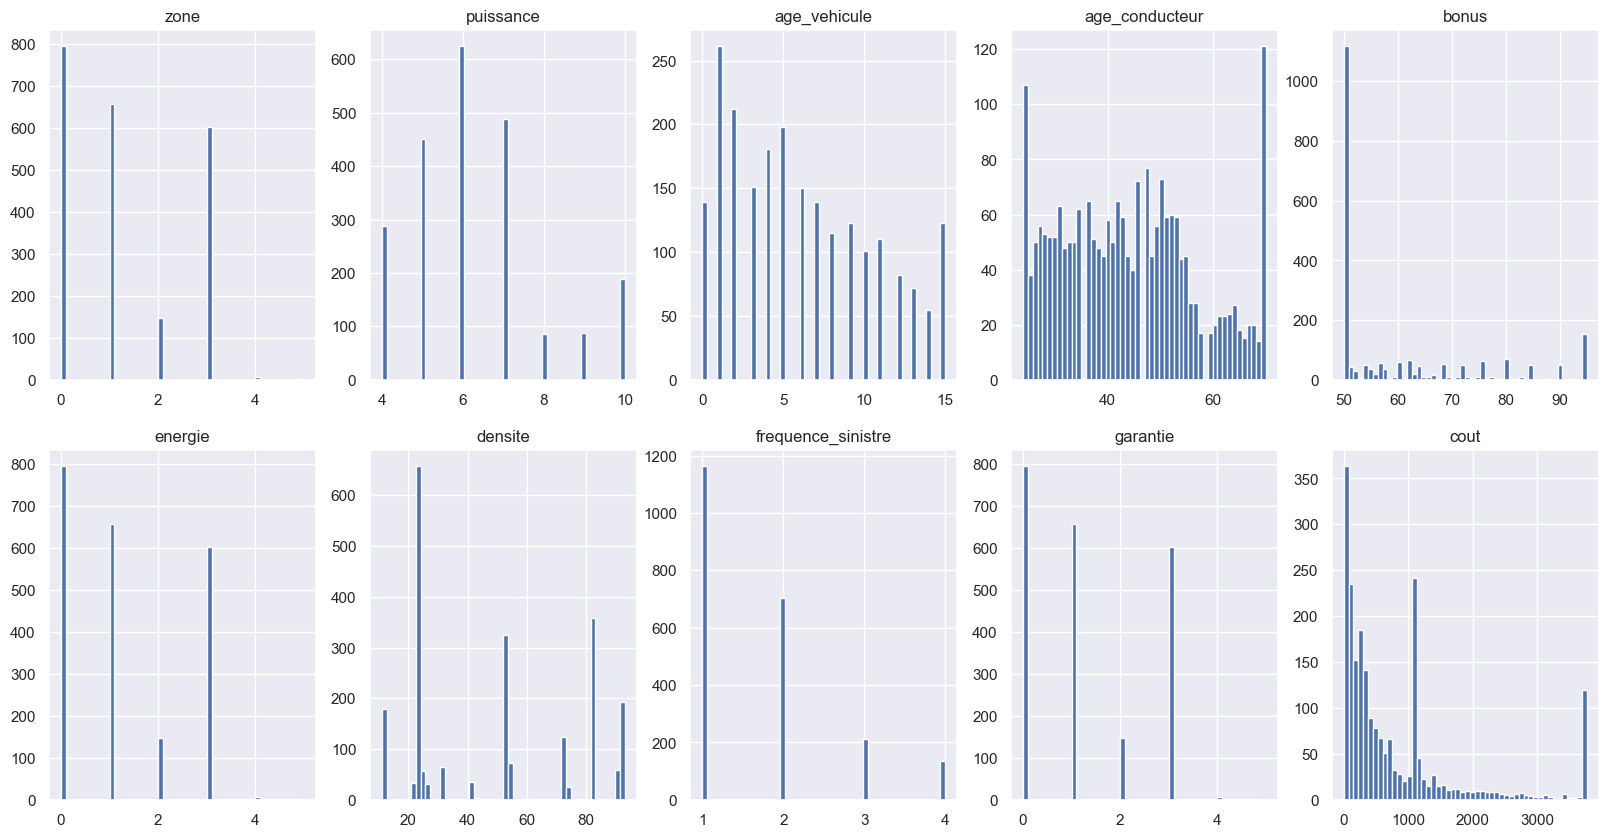

In [53]:
# Visualisation de la distribution des variables
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()

for i, column in enumerate(train.columns):
    axs[i].hist(train[column], bins=50)
    axs[i].set_title(column)

plt.show()

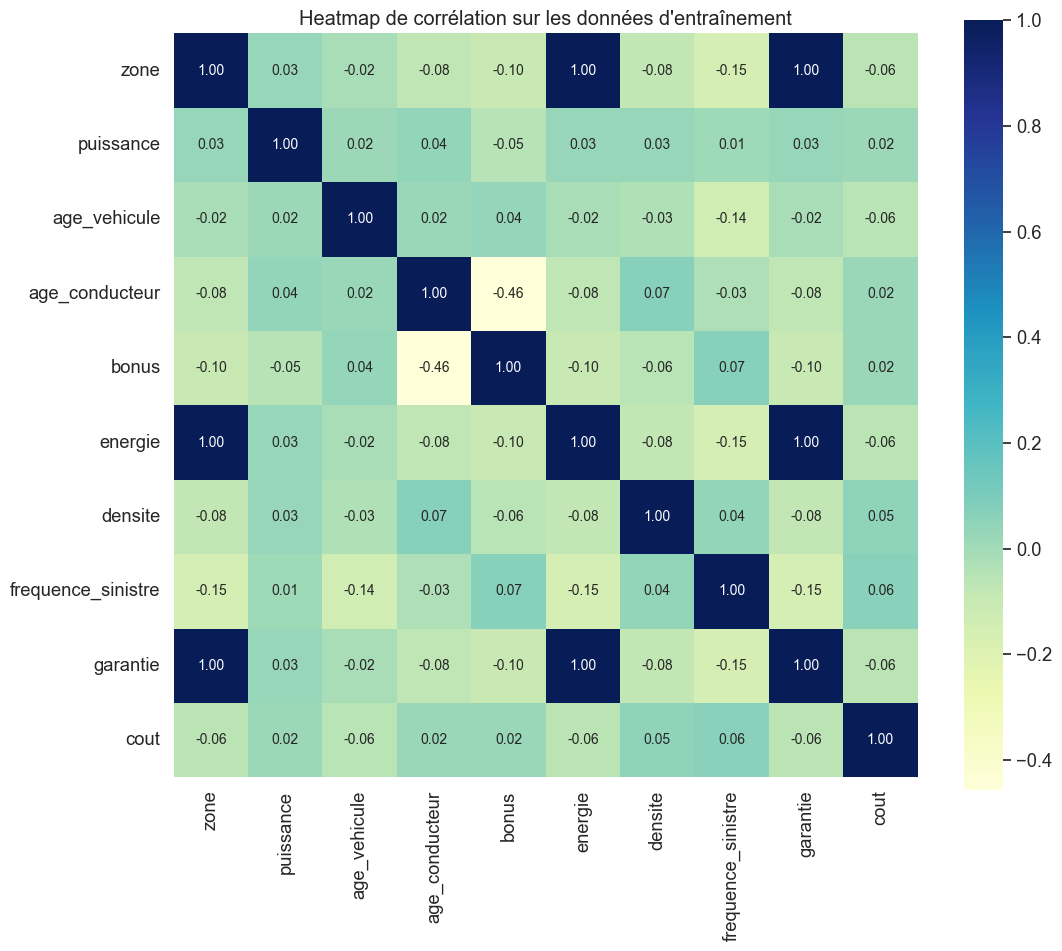

In [54]:
# Calcul de la matrice de corrélation sur les données d'entraînement
corr_matrix_train = train.corr()


sns.set(font_scale=1.2)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_train, cmap="YlGnBu", annot=True, annot_kws={"size": 10}, square=True, fmt=".2f")

# Affichage du graphique
import matplotlib.pyplot as plt

plt.title("Heatmap de corrélation sur les données d'entraînement")
plt.show()

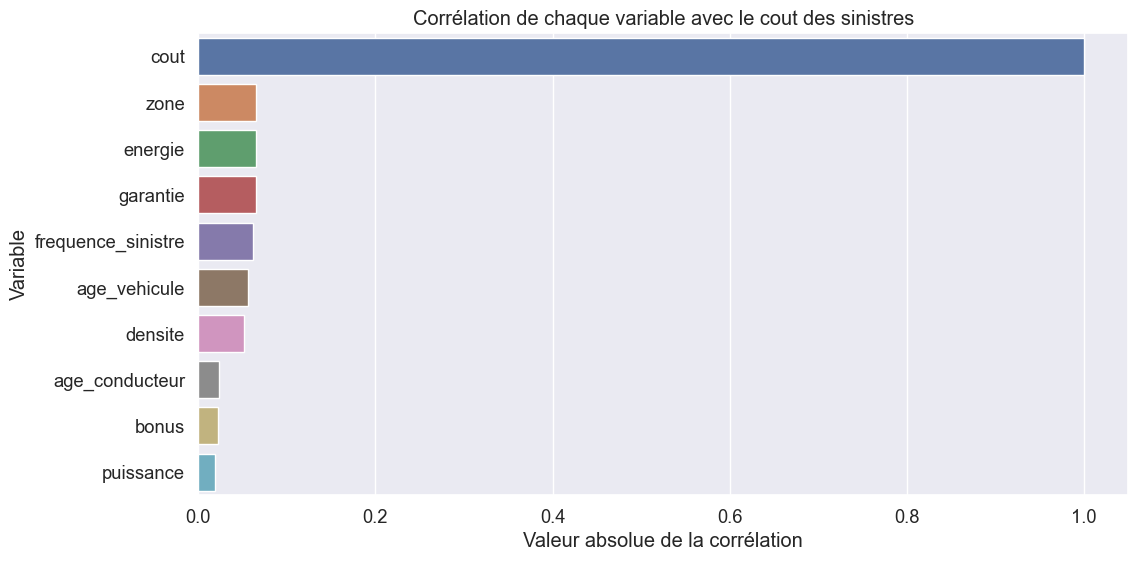

In [87]:
# Calcul de la corrélation entre chaque variable et la variable cible (en valeur absolue)
correlations = abs(train.corr()["cout"]).sort_values(ascending=False)

# Représentation graphique des corrélations
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel("Valeur absolue de la corrélation")
plt.ylabel("Variable")
plt.title("Corrélation de chaque variable avec le cout des sinistres")
plt.show()

In [56]:
# Extraction des colonnes de variables explicatives
X = Actuar.drop("cout", axis=1)

In [63]:
Y=Actuar['cout']

In [65]:
Y

0         0.00
1         0.00
2       687.82
3        96.64
4        70.88
         ...  
2760    156.23
2761     74.15
2762    325.57
2763    387.04
2764    231.20
Name: cout, Length: 2765, dtype: float64

In [68]:
import statsmodels.api as sm
# Séparation des variables prédictives et de la variable cible
X_train = train.drop("cout", axis=1)
Y_train = train["cout"]


X_test = test.drop("cout", axis=1)
Y_test = test["cout"]

# Fit du modèle linéaire
lr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Obtention du tableau de résultats
results_table = lr_model.summary2().tables[1]
results_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,432.751468,185.916325,2.327668,0.020020,68.161948,797.340989
zone,-13.371392,5.803878,-2.303872,0.021322,-24.753035,-1.989750
puissance,11.470362,12.527886,0.915586,0.359984,-13.097334,36.038058
age_vehicule,-11.422195,4.730809,-2.414427,0.015841,-20.699504,-2.144885
age_conducteur,2.585051,1.794601,1.440460,0.149879,-0.934236,6.104337
bonus,2.401472,1.616373,1.485716,0.137497,-0.768302,5.571246
energie,-13.371392,5.803878,-2.303872,0.021322,-24.753035,-1.989750
densite,1.520183,0.746040,2.037669,0.041702,0.057168,2.983199
frequence_sinistre,47.968700,24.146395,1.986578,0.047093,0.616632,95.320767
garantie,-13.371392,5.803878,-2.303872,0.021322,-24.753035,-1.989750


In [67]:
Y

0         0.00
1         0.00
2       687.82
3        96.64
4        70.88
         ...  
2760    156.23
2761     74.15
2762    325.57
2763    387.04
2764    231.20
Name: cout, Length: 2765, dtype: float64

In [69]:
#Ajouter une constante a notre modele
X=sm.add_constant(X)

In [70]:
#Transformation logarithmique du cout des sinistes
Y_log=np.log(Y + 1)


In [71]:
#Ajuster le modele de regression lineaire sur les donnees transformees
model=sm.OLS(Y_log,X).fit()

In [73]:
#Resume du modele
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   cout   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.483
Date:                Mon, 22 Jul 2024   Prob (F-statistic):              0.168
Time:                        15:51:03   Log-Likelihood:                -6130.8
No. Observations:                2765   AIC:                         1.228e+04
Df Residuals:                    2757   BIC:                         1.232e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.2886      0

Ces résultats proviennent d'une régression OLS (Ordinary Least Squares) appliquée à votre modèle de coût (variable dépendante) en fonction de plusieurs variables indépendantes. Voici une interprétation des principaux résultats :

### Statistiques du modèle :
- **R-carré (R-squared)** : 0.004
  - Cela signifie que seulement environ 0.4% de la variance dans la variable dépendante (coût) est expliquée par les variables indépendantes incluses dans le modèle. Un R-carré faible suggère que le modèle ne capture pas bien la variabilité des données.

- **R-carré ajusté (Adj. R-squared)** : 0.001
  - Il est légèrement plus bas que le R-carré, indiquant que l'ajout de variables indépendantes n'a pas amélioré de manière significative l'ajustement du modèle.

- **F-statistique** : 1.483
  - Avec une p-valeur de 0.168, cette statistique ne fournit pas suffisamment de preuves pour rejeter l'hypothèse nulle que tous les coefficients des variables indépendantes sont nuls simultanément. Cela suggère que le modèle dans son ensemble pourrait ne pas être significatif.

### Coefficients des variables indépendantes :
- Les coefficients indiquent l'effet attendu sur la variable dépendante (coût) pour chaque unité de changement dans la variable indépendante, toutes choses étant égales par ailleurs.

- **Significativité des coefficients** : 
  - Seul le coefficient pour **frequence_sinistre** est statistiquement significatif à un niveau de signification de 5% (p-valeur = 0.007), indiquant que la fréquence des sinistres a un effet significatif négatif sur le coût.

- Les autres coefficients (zone, puissance, âge du véhicule, âge du conducteur, bonus, énergie, densité, garantie) ne sont pas statistiquement significatifs à un niveau de 5% (p-valeurs > 0.05).

### Autres remarques :
- **Omnibus** : Le test Omnibus indique une significativité globale du modèle (p-valeur < 0.05), suggérant que certaines des variables indépendantes en ensemble ont un effet sur la variable dépendante.
  
- **Multicollinéarité** : Le modèle pourrait souffrir de problèmes de multicollinéarité, ce qui peut affecter la précision des estimations des coefficients.

En résumé, ce modèle montre des faibles capacités prédictives (R-carré faible) et la plupart des variables indépendantes ne semblent pas avoir un effet significatif sur le coût des sinistres, à l'exception de la fréquence des sinistres.

In [93]:
from sklearn.metrics import mean_squared_error, r2_score


# Obtention des prédictions et des métriques d'évaluation
y_train_pred = lr_model.predict(sm.add_constant(X_train))
y_test_pred = lr_model.predict(sm.add_constant(X_test))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [94]:
# Construction du tableau de résultats

df_metrics = pd.DataFrame({
    'Métrique': ['R2', 'MSE', 'RMSE'],
    'Train': [r2_train, mse_train, rmse_train],
    'Test': [r2_test, mse_test, rmse_test]
})

print(df_metrics)

  Métrique          Train           Test
0       R2       0.012993       0.019092
1      MSE  939276.552089  830037.142980
2     RMSE     969.162810     911.063743


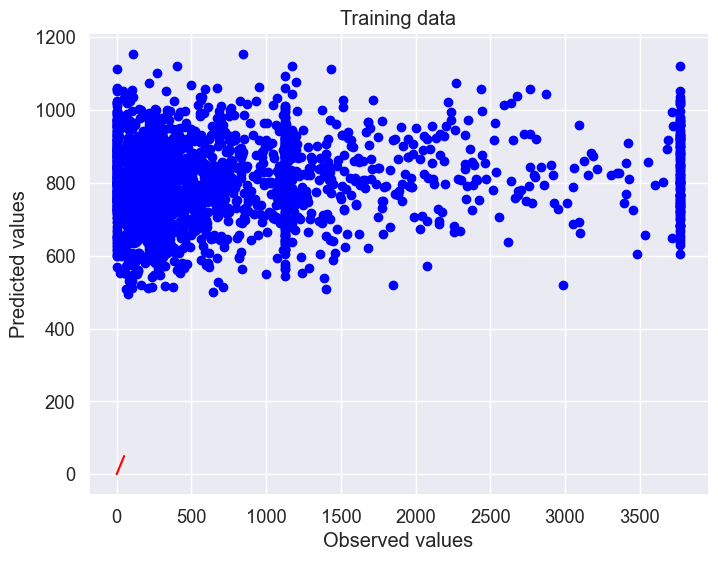

In [97]:
 #Tracer les valeurs observées en fonction des valeurs prédites sur les données d'entraînement

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Training data')
plt.plot(np.arange(0, 55, 5), np.arange(0, 55, 5), color='red')
plt.show()

In [89]:
from statsmodels.stats.diagnostic import linear_reset

In [90]:
# Effectuer le test de Ramsey RESET
reset_test = linear_reset(model, power=2, use_f=True)

# Afficher les résultats
print('F-statistic:', reset_test.fvalue)
print('p-value:', reset_test.pvalue)


F-statistic: 0.5184717158961908
p-value: 0.47155539324817264


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\diagnostic.py:1065: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


In [77]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [78]:
#Choix de Variables
vif_data=pd.DataFrame()
vif_data['Feature']=X.columns
vif_data['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

print(vif_data)

              Feature        VIF
0               const  82.629525
1                zone        inf
2           puissance   1.005274
3        age_vehicule   1.021108
4      age_conducteur   1.305906
5               bonus   1.318651
6             energie        inf
7             densite   1.009273
8  frequence_sinistre   1.042764
9            garantie        inf


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Ces résultats présentent les valeurs du facteur d'inflation de la variance (VIF) pour chaque variable du modèle de régression. Voici une interprétation :

- **VIF (Facteur d'Inflation de la Variance)** : Le VIF mesure l'ampleur à laquelle la variance d'un coefficient de régression est augmentée en raison de la corrélation avec d'autres variables dans le modèle. Un VIF élevé (généralement supérieur à 10) suggère une forte corrélation entre la variable correspondante et les autres variables explicatives dans le modèle, ce qui peut entraîner une instabilité dans les estimations des coefficients.

- **Interprétation des valeurs de VIF** :
  - Pour les variables "constante", "puissance", "age_vehicule", "age_conducteur", "bonus", "densite" et "frequence_sinistre", les valeurs de VIF sont proches de 1, ce qui indique qu'il n'y a pas de forte corrélation avec d'autres variables dans le modèle.
  - Les variables "zone", "energie" et "garantie" ont des valeurs de VIF infinies, ce qui suggère une forte corrélation avec d'autres variables dans le modèle. Une valeur infinie indique souvent une parfaite multicollinéarité, ce qui peut entraîner des estimations peu fiables des coefficients.

En résumé, ces résultats suggèrent qu'il existe une forte multicollinéarité entre les variables "zone", "energie" et "garantie" et les autres variables dans le modèle. Cela pourrait affecter la fiabilité des estimations des coefficients de régression associées à ces variables et nécessiterait une attention particulière lors de l'interprétation des résultats du modèle.

In [79]:
#Analyser les residus
residuals=model.resid

In [80]:
residuals

0      -5.524473
1      -5.602011
2       0.900520
3      -1.044156
4      -1.278235
          ...   
2760   -0.494302
2761   -1.200302
2762    0.329372
2763    0.454612
2764   -0.087054
Length: 2765, dtype: float64

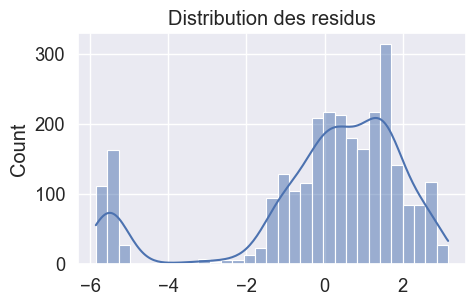

In [81]:
#Visualisation des residus
sns.histplot(residuals,kde=True)
plt.title('Distribution des residus')
plt.show()

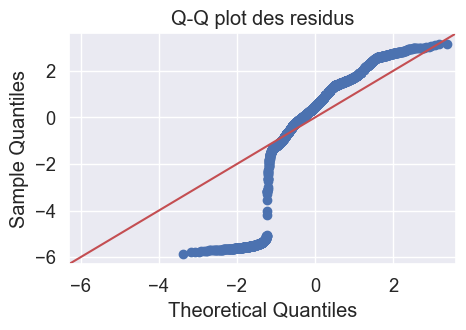

In [82]:
#Q-Q plot des residus
sm.qqplot(residuals,line='45')
plt.title('Q-Q plot des residus')
plt.show()

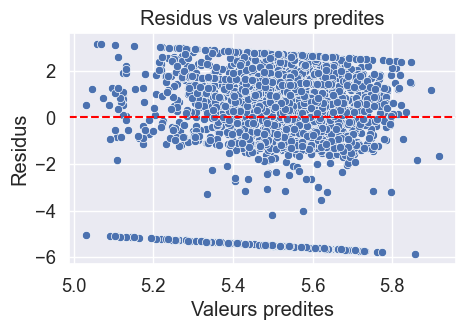

In [83]:
#Graphique des residus vs valeurs predites
fitted_values=model.fittedvalues
sns.scatterplot(x=fitted_values,y=residuals)
plt.axhline(0,color='red',linestyle='--')
plt.xlabel('Valeurs predites')
plt.ylabel('Residus')
plt.title('Residus vs valeurs predites')
plt.show()

In [84]:
#Teste de validite du modele par la verification du  des hypotheses
#Test de normalite des residus
from scipy.stats import shapiro,normaltest

shapiro_test=shapiro(residuals)
normaltest_test=normaltest(residuals)
print('Shapiro-Wilk test:',shapiro_test)
print('D\'Agostino\'s K^2 test:',normaltest_test)


Shapiro-Wilk test: ShapiroResult(statistic=0.823623776435852, pvalue=0.0)
D'Agostino's K^2 test: NormaltestResult(statistic=627.8298323143897, pvalue=4.661053907567824e-137)


Ces résultats proviennent de tests de normalité des résidus d'un modèle statistique. Voici une interprétation :

- **Test de Shapiro-Wilk** : Ce test évalue si un échantillon de données suit une distribution normale. La statistique de test est proche de 1 pour les données normalement distribuées. Une p-value inférieure au niveau de signification (généralement 0,05) indique un rejet de l'hypothèse nulle selon laquelle les données suivent une distribution normale. Dans ce cas, la p-value est inférieure à 0.05 (0.0), ce qui suggère que les résidus ne suivent pas une distribution normale.

- **Test de D'Agostino's K^2** : Ce test est une autre méthode pour évaluer la normalité des résidus. Il combine l'asymétrie et l'aplatissement (kurtosis) pour calculer la statistique de test. Une p-value faible (généralement inférieure à 0,05) indique un rejet de l'hypothèse nulle de normalité des données. Dans ce cas, la p-value est très proche de zéro (2.7812995291713716e-138), ce qui confirme le rejet de l'hypothèse de normalité des résidus.

En résumé, ces résultats suggèrent que les résidus du modèle ne suivent pas une distribution normale, ce qui peut avoir des implications sur l'interprétation des résultats du modèle et nécessiterait une attention particulière lors de l'application de méthodes statistiques qui supposent une distribution normale des résidus.

In [85]:
#Test de l'homoscedasticite
from statsmodels.stats.diagnostic import het_breuschpagan

breusch_pagan_test=het_breuschpagan(residuals,X)
print('Breusch-Pagan test:',breusch_pagan_test)

Breusch-Pagan test: (52.834359965349385, 3.1420552195124955e-08, 7.672536571318157, 3.3246644100172976e-09)


Les résultats que vous avez fournis semblent être issus du test de Breusch-Pagan, utilisé pour détecter l'hétéroscédasticité dans les résidus d'un modèle de régression. Voici comment interpréter ces résultats :

1. **Statistique de test** : 52.834359965349385
   - Il s'agit de la statistique de test du test de Breusch-Pagan. Elle mesure à quel point les résidus du modèle présentent des signes d'hétéroscédasticité.

2. **P-valeur** : 3.1420552195124955e-08 (en notation scientifique, environ 0.00000003142)
   - La p-valeur est très faible, indiquant que les résidus présentent une hétéroscédasticité significative.

3. **Degrés de liberté** : 7.672536571318157
   - Cela fait référence aux degrés de liberté du test.

4. **P-valeur ajustée** : 3.3246644100172976e-09 (en notation scientifique, environ 0.00000000332)
   - C'est une p-valeur ajustée qui confirme la significativité de l'hétéroscédasticité dans les résidus.

### Interprétation :
- Étant donné que la p-valeur est très faible (beaucoup plus petite que le seuil de 0.05 généralement utilisé), nous rejetons l'hypothèse nulle selon laquelle il n'y a pas d'hétéroscédasticité dans les résidus. En d'autres termes, il y a une forte indication que les résidus de votre modèle de régression sont hétéroscédastiques.

### Conséquences :
- L'hétéroscédasticité peut affecter la précision des estimations des paramètres du modèle, en particulier des intervalles de confiance et des tests d'hypothèses sur les coefficients.

### Actions recommandées :
- Considérez l'utilisation de techniques de régression robustes à l'hétéroscédasticité, telles que les méthodes de régression robustes ou les transformations des variables.
- Effectuez d'autres diagnostics pour mieux comprendre la nature et l'impact de l'hétéroscédasticité sur vos résultats de régression.

In [86]:
#Test d'autocorrelation des residus
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test=durbin_watson(residuals)
print('Durbin-Watson test:',durbin_watson_test)

Durbin-Watson test: 2.012625096723772


Le test de Durbin-Watson est une mesure de l'autocorrélation des résidus dans un modèle de régression. Voici une interprétation du résultat :

La statistique de test de Durbin-Watson est de 2.012625096723772. Cette statistique prend des valeurs entre 0 et 4. Une valeur proche de 2 indique une absence d'autocorrélation des résidus. Dans ce cas, la valeur est légèrement inférieure à 2, ce qui suggère une légère autocorrélation positive des résidus, mais elle est proche de 2, ce qui indique que cette autocorrélation est faible.

En résumé, le test de Durbin-Watson indique une faible autocorrélation positive des résidus dans le modèle de régression.

In [91]:
residuals.mean()

-4.612745789111681e-15